## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [5]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [6]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cpu


In [7]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [8]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
data_df = data_df.fillna('')
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of          depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0            1     -1.220007     590.851292   -30.129462     -35.559056   
1            2     -1.220007     590.851292   -30.129462     -35.559056   
2            3     -1.220007     590.851292   -30.129462     -35.559056   
3            4     -1.220007     590.851292   -30.129462     -35.559056   
4            5     -1.220007     590.851292   -30.129462     -35.559056   
...        ...           ...            ...          ...            ...   
3065970     21      3.860010     597.535984    25.682372      36.658380   
3065971     22      3.860010     597.535984    25.682372      36.658380   
3065972     23      3.860010     597.535984    25.682372      36.658380   
3065973     24      3.860010     597.535984    25.682372      36.658380   
3065974     25      3.860010     597.535984    25.682372      36.658380   

         Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0   

In [9]:
training_frac = 0.60
depth_steps = 25
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 122639
Number of training points: 1839575


# Normalizing Data

In [10]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [11]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_heat01']]

# Loading Models

In [12]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 
                 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice','temp_initial00']
m0_output_columns = ['temp_heat01']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/heating_model_time.pth"
m0_layers = [len(m0_input_columns), 32, 32, len(m0_output_columns)]

heating_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
heating_model.load_state_dict(m0_checkpoint)
heating_model = heating_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

In [13]:
m1_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'Area_m2', 
                 'buoyancy', 'day_of_year', 'time_of_day', 'diffusivity', 'temp_heat01']
m1_output_columns = ['temp_diff02']

m1_input_column_ix = [data_df.columns.get_loc(column) for column in m1_input_columns]
m1_output_column_ix = [data_df.columns.get_loc(column) for column in m1_output_columns]

m1_PATH = f"./../02_training/saved_models/heat_diffusion_model_time.pth"
m1_layers = [len(m1_input_columns), 32, 32, len(m1_output_columns)]

heat_diff_model = MLP(m1_layers, activation="gelu")
m1_checkpoint = torch.load(m1_PATH, map_location=torch.device('cpu'))
heat_diff_model.load_state_dict(m1_checkpoint)
heat_diff_model = heat_diff_model.to(device)

Initializing Network with Xavier Initialization..


## Mixing Model

In [14]:
m2_input_columns = ['depth', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'day_of_year', 'time_of_day', 
                    'ice', 'snow', 'snowice','temp_diff02']
m2_output_columns = ['temp_mix03']

m2_input_column_ix = [data_df.columns.get_loc(column) for column in m2_input_columns]
m2_output_column_ix = [data_df.columns.get_loc(column) for column in m2_output_columns]

m2_PATH = f"./../02_training/saved_models/mixing_model_time.pth"
m2_layers = [len(m2_input_columns), 32, 32, len(m2_output_columns)]

mixing_model = MLP(m2_layers, activation="gelu")
m2_checkpoint = torch.load(m2_PATH, map_location=torch.device('cpu'))
mixing_model.load_state_dict(m2_checkpoint)
mixing_model = mixing_model.to(device)

Initializing Network with Xavier Initialization..


# Convection Model

In [15]:
m3_input_columns = ['depth', 'day_of_year', 'time_of_day', 'temp_mix03']
m3_output_columns = ['temp_conv04']

m3_input_column_ix = [data_df.columns.get_loc(column) for column in m3_input_columns]
m3_output_column_ix = [data_df.columns.get_loc(column) for column in m3_output_columns]

m3_PATH = f"./../02_training/saved_models/convection_model_time.pth"
m3_layers = [len(m3_input_columns), 32, 32, len(m3_output_columns)]

convection_model = MLP(m3_layers, activation="gelu")
m3_checkpoint = torch.load(m3_PATH, map_location=torch.device('cpu'))
convection_model.load_state_dict(m3_checkpoint)
convection_model = convection_model.to(device)

Initializing Network with Xavier Initialization..


# Ice Model

In [16]:
m4_input_columns = ['depth', 'day_of_year', 'time_of_day', 
                    'ice', 'snow', 'snowice','temp_conv04']
m4_output_columns = ['temp_total05']

m4_input_column_ix = [data_df.columns.get_loc(column) for column in m4_input_columns]
m4_output_column_ix = [data_df.columns.get_loc(column) for column in m4_output_columns]

m4_PATH = f"./../02_training/saved_models/ice_model_time.pth"
m4_layers = [len(m4_input_columns), 32, 32, len(m4_output_columns)]

ice_model = MLP(m4_layers, activation="gelu")
m4_checkpoint = torch.load(m4_PATH, map_location=torch.device('cpu'))
ice_model.load_state_dict(m4_checkpoint)
ice_model = ice_model.to(device)

Initializing Network with Xavier Initialization..


In [17]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [18]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [19]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [20]:
# Create data set
batch_size = 1000

assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [21]:
print(train_data.shape)
print(test_data.shape)

(1839575, 26)
(1226400, 26)


In [22]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [23]:
#keeping track of the mean and standard deviations

input_mean, input_std = train_mean[m1_input_column_ix], train_std[m1_input_column_ix]
output_mean, output_std = train_mean[m1_output_column_ix], train_std[m1_output_column_ix]

mean_diff = torch.tensor(input_mean[m1_input_column_ix[13]]).to(device)
std_diff = torch.tensor(input_std[m1_input_column_ix[13]]).to(device)

mean_temp = torch.tensor(input_mean[m1_input_column_ix[14]]).to(device)
std_temp = torch.tensor(input_std[m1_input_column_ix[14]]).to(device)

mean_out = torch.tensor(output_mean).to(device)
std_out = torch.tensor(output_std).to(device)
    
def implicit_diffusion(diff, temp, dt=3600, dx=1, depth_steps=25):
    # de-normalise data
    diff = diff * std_diff + mean_diff
    diff = diff.view(-1, depth_steps)
    
    # INPUT DATA FROM PREVIOUS MODULE
    t = temp * std_temp + mean_temp # temperature profile from previous module output
    t = t.view(-1, depth_steps)
    
    # IMPLEMENTATION OF CRANK-NICHOLSON SCHEME
#     len_t = t.shape[1]
    y = torch.zeros((t.shape[0], depth_steps, depth_steps), dtype=torch.float64).to(device)

    alpha = (dt/dx**2) * diff

    az = - alpha # subdiagonal
    bz = 2 * (1 + alpha) # diagonal
    cz = - alpha # superdiagonal
    
    bz[:, 0] = 1
    az[:, depth_steps-2] = 0
    bz[:, depth_steps-1] = 1
    cz[:, 0] = 0
    
    az = az[:,1:]
    cz = cz[:,:-1]

    y = torch.diag_embed(bz, offset=0)+torch.diag_embed(az,offset=-1)+torch.diag_embed(cz,offset=1) #slightly efficient way of computing the diagonal matrices
    y[:, depth_steps-1, depth_steps-1] = 1
    
    mn = torch.zeros_like(t)  
    mn[:, 0] = t[:, 0]
    mn[:,depth_steps-1] = t[:, depth_steps-1]
    
    mn[:, 1:depth_steps-1] = alpha[:, 1:depth_steps-1]*t[:, :depth_steps-2] + 2 * (1 - alpha[:,1:depth_steps-1])*t[:,1:depth_steps-1] + alpha[:,1:depth_steps-1]*t[:,1:depth_steps-1] #is be same as the loop
    
    # DERIVED TEMPERATURE OUTPUT FOR NEXT MODULE
    proj = torch.linalg.solve(y, mn)

    mean, std, var = torch.mean(proj), torch.std(proj), torch.var(proj)
    proj = (proj-mean_out)/std_out

    proj = proj.to(torch.float32)
    proj = proj.view(-1, 1)
    return proj

In [24]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [25]:
print(m1_input_column_ix)
print(m1_input_column_ix[:-1])
print(m1_input_column_ix[:-2])
print(m1_input_column_ix[14])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 17, 13, 14]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 17, 13]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 17]
14


In [26]:
def get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, loader, plot = True):    
    heating_model.eval()
    heat_diff_model.eval()
    mixing_model.eval()
    convection_model.eval()
    ice_model.eval()

    mean = torch.tensor(train_mean[m4_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m4_output_column_ix]).float().to(device)

    m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
    m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        #model 2
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m0_pred], dim=-1)
        #m1_input = x[:, m1_input_column_ix]
            
        #model 1
        # m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        
        temp_input = m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
       # print(temp_input)
        
        proj = heat_diff_model(m1_input)
        
        pred = implicit_diffusion(proj, m0_pred)        
        m1_pred = pred.to(dtype=torch.float32)
        
        #print(m1_pred)
        
        if plot:
            m1_y_true = x[:, m1_output_column_ix[0]] * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            m1_y_pred = m1_pred * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 1] = rmse(m1_y_true.squeeze(), m1_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m1", rmse(m1_y_true.flatten(), m1_y_pred.flatten()))

        #model 2
        m2_input = torch.cat([x[:, m2_input_column_ix[:-1]], m1_pred], dim=-1)
        m2_pred = mixing_model(m2_input)
            
        if plot:
            m2_y_true = x[:, m2_output_column_ix] * torch.tensor(train_std[m2_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m2_output_column_ix[0]]).to(device)
            m2_y_pred = m2_pred * torch.tensor(train_std[m2_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m2_output_column_ix[0]]).to(device)
            rmse_models[ix, 2] = rmse(m2_y_true.squeeze(), m2_y_pred.squeeze())
            print("RMSE of after m2", rmse(m2_y_true.flatten(), m2_y_pred.flatten()))

        #model 3
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m2_pred], dim=-1)
        m3_pred = convection_model(m3_input)
            
        if plot:
            m3_y_true = x[:, m3_output_column_ix] * torch.tensor(train_std[m3_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m3_output_column_ix[0]]).to(device)
            m3_y_pred = m3_pred * torch.tensor(train_std[m3_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m3_output_column_ix[0]]).to(device)
            rmse_models[ix, 3] = rmse(m3_y_true.squeeze(), m3_y_pred.squeeze())
            print("RMSE of after m3", rmse(m3_y_true.flatten(), m3_y_pred.flatten()))

        #model 4
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m3_pred], dim=-1)
        m4_pred = ice_model(m4_input)
            
        if plot:
            m4_y_true = x[:, m4_output_column_ix] * std + mean
            m4_y_pred = m4_pred * std + mean
            rmse_models[ix, 4] = rmse(m4_y_true.squeeze(), m4_y_pred.squeeze())
            print("RMSE of after m4", rmse(m4_y_true.flatten(), m4_y_pred.flatten()))

        y_true = x[:, m4_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m4_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [27]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='seismic', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='seismic', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [28]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.00029189952
RMSE of after m1 0.8203211
RMSE of after m2 0.42201194
RMSE of after m3 0.17701489
RMSE of after m4 0.17674342
RMSE of after m0 0.0002657973
RMSE of after m1 0.7427424
RMSE of after m2 0.69531924
RMSE of after m3 0.1821392
RMSE of after m4 0.18210119
RMSE of after m0 0.0002682778
RMSE of after m1 0.73037225
RMSE of after m2 0.19040965
RMSE of after m3 0.09940744
RMSE of after m4 0.09965393
RMSE of after m0 0.00026245267
RMSE of after m1 0.7214254
RMSE of after m2 0.5366472
RMSE of after m3 0.09996168
RMSE of after m4 0.10006954
RMSE of after m0 0.00025182773
RMSE of after m1 0.6361745
RMSE of after m2 0.4576226
RMSE of after m3 0.08201759
RMSE of after m4 0.08199401
RMSE of after m0 0.00023454186
RMSE of after m1 0.57111347
RMSE of after m2 0.47717556
RMSE of after m3 0.08284427
RMSE of after m4 0.08277907
RMSE of after m0 0.00024618732
RMSE of after m1 0.50591993
RMSE of after m2 0.41464084
RMSE of after m3 0.07802256
RMSE of after m4 0.078010455
RMSE of

RMSE of after m0 0.00018953046
RMSE of after m1 0.7626616
RMSE of after m2 0.5954135
RMSE of after m3 0.13294618
RMSE of after m4 0.1330072
RMSE of after m0 0.00019355386
RMSE of after m1 0.73838216
RMSE of after m2 0.65372175
RMSE of after m3 0.17004749
RMSE of after m4 0.17008716
RMSE of after m0 0.00019221171
RMSE of after m1 0.74458754
RMSE of after m2 0.69155365
RMSE of after m3 0.14579324
RMSE of after m4 0.14582977
RMSE of after m0 0.0002317202
RMSE of after m1 0.88294566
RMSE of after m2 0.1277719
RMSE of after m3 0.13936819
RMSE of after m4 0.13942407
RMSE of after m0 0.00024125747
RMSE of after m1 0.8098925
RMSE of after m2 0.57803804
RMSE of after m3 0.15656312
RMSE of after m4 0.15660006
RMSE of after m0 0.0002479283
RMSE of after m1 0.7142785
RMSE of after m2 0.7193236
RMSE of after m3 0.12397009
RMSE of after m4 0.124019384
RMSE of after m0 0.00028115438
RMSE of after m1 0.7759257
RMSE of after m2 0.7079838
RMSE of after m3 0.20766242
RMSE of after m4 0.20770358
RMSE of a

RMSE of after m1 0.7417084
RMSE of after m2 0.7483849
RMSE of after m3 0.097948454
RMSE of after m4 0.09796582
RMSE of after m0 0.0011788864
RMSE of after m1 0.7489425
RMSE of after m2 0.75569946
RMSE of after m3 0.08087292
RMSE of after m4 0.080919445
RMSE of after m0 0.001296889
RMSE of after m1 0.75636315
RMSE of after m2 0.7610303
RMSE of after m3 0.0750912
RMSE of after m4 0.07511111
RMSE of after m0 0.0011392018
RMSE of after m1 0.7633248
RMSE of after m2 0.7690058
RMSE of after m3 0.077664845
RMSE of after m4 0.077668704
RMSE of after m0 0.0012599701
RMSE of after m1 0.76541466
RMSE of after m2 0.77168727
RMSE of after m3 0.08943724
RMSE of after m4 0.08943507
RMSE of after m0 0.001342939
RMSE of after m1 0.7504316
RMSE of after m2 0.75708556
RMSE of after m3 0.12008008
RMSE of after m4 0.12008799
RMSE of after m0 0.0014309122
RMSE of after m1 0.75115705
RMSE of after m2 0.7598687
RMSE of after m3 0.13388813
RMSE of after m4 0.13391867
RMSE of after m0 0.0012145203
RMSE of after

RMSE of after m0 0.00025170465
RMSE of after m1 0.4932165
RMSE of after m2 0.4441209
RMSE of after m3 0.13290344
RMSE of after m4 0.13291377
RMSE of after m0 0.00022770307
RMSE of after m1 0.44558653
RMSE of after m2 0.3224958
RMSE of after m3 0.118109435
RMSE of after m4 0.11809507
RMSE of after m0 0.0002532996
RMSE of after m1 0.3972177
RMSE of after m2 0.36223683
RMSE of after m3 0.11301277
RMSE of after m4 0.11297661
RMSE of after m0 0.0002425739
RMSE of after m1 0.36095172
RMSE of after m2 0.3648795
RMSE of after m3 0.10721231
RMSE of after m4 0.10717733
RMSE of after m0 0.0002036183
RMSE of after m1 0.33959365
RMSE of after m2 0.33394822
RMSE of after m3 0.052376397
RMSE of after m4 0.05233903
RMSE of after m0 0.00031037958
RMSE of after m1 0.35891858
RMSE of after m2 0.279539
RMSE of after m3 0.063992076
RMSE of after m4 0.06384551
RMSE of after m0 0.00027318232
RMSE of after m1 0.4306064
RMSE of after m2 0.20033573
RMSE of after m3 0.055300385
RMSE of after m4 0.05516585
RMSE o

RMSE of after m0 0.00027416492
RMSE of after m1 0.27552164
RMSE of after m2 0.27531564
RMSE of after m3 0.017967327
RMSE of after m4 0.01764388
RMSE of after m0 0.00029273433
RMSE of after m1 0.28340778
RMSE of after m2 0.28392637
RMSE of after m3 0.0155313155
RMSE of after m4 0.014823384
RMSE of after m0 0.00023516086
RMSE of after m1 0.28771564
RMSE of after m2 0.288784
RMSE of after m3 0.014435525
RMSE of after m4 0.014143904
RMSE of after m0 0.00021839596
RMSE of after m1 0.2937227
RMSE of after m2 0.2940462
RMSE of after m3 0.013974931
RMSE of after m4 0.01408981
RMSE of after m0 0.00022245028
RMSE of after m1 0.3006597
RMSE of after m2 0.30050185
RMSE of after m3 0.015384844
RMSE of after m4 0.015476181
RMSE of after m0 0.00028560485
RMSE of after m1 0.3106437
RMSE of after m2 0.30689302
RMSE of after m3 0.016583312
RMSE of after m4 0.016052952
RMSE of after m0 0.00021102739
RMSE of after m1 0.31934544
RMSE of after m2 0.31771433
RMSE of after m3 0.021165982
RMSE of after m4 0.02

RMSE of after m0 0.0009972628
RMSE of after m1 0.7475576
RMSE of after m2 0.7548726
RMSE of after m3 0.16944821
RMSE of after m4 0.16944717
RMSE of after m0 0.000971647
RMSE of after m1 0.7130916
RMSE of after m2 0.7178671
RMSE of after m3 0.19708411
RMSE of after m4 0.19709064
RMSE of after m0 0.0009872986
RMSE of after m1 0.72509766
RMSE of after m2 0.7279685
RMSE of after m3 0.18404739
RMSE of after m4 0.18405806
RMSE of after m0 0.00090003
RMSE of after m1 0.75067735
RMSE of after m2 0.75789684
RMSE of after m3 0.16926366
RMSE of after m4 0.16926488
RMSE of after m0 0.00093086855
RMSE of after m1 0.75830173
RMSE of after m2 0.76386243
RMSE of after m3 0.14829814
RMSE of after m4 0.1483043
RMSE of after m0 0.0010846726
RMSE of after m1 0.74005383
RMSE of after m2 0.7483554
RMSE of after m3 0.14183396
RMSE of after m4 0.14185673
RMSE of after m0 0.0010870242
RMSE of after m1 0.7551671
RMSE of after m2 0.7612845
RMSE of after m3 0.12713216
RMSE of after m4 0.12715052
RMSE of after m0 

RMSE of after m2 0.44035158
RMSE of after m3 0.1606299
RMSE of after m4 0.16061363
RMSE of after m0 0.0010328258
RMSE of after m1 0.59260947
RMSE of after m2 0.5840039
RMSE of after m3 0.23121889
RMSE of after m4 0.23125663
RMSE of after m0 0.0010135133
RMSE of after m1 0.62747663
RMSE of after m2 0.6252572
RMSE of after m3 0.25754002
RMSE of after m4 0.25758442
RMSE of after m0 0.0009301889
RMSE of after m1 0.63042754
RMSE of after m2 0.64060515
RMSE of after m3 0.27815345
RMSE of after m4 0.27819437
RMSE of after m0 0.0008347885
RMSE of after m1 0.49678499
RMSE of after m2 0.4995885
RMSE of after m3 0.18589523
RMSE of after m4 0.1859142
RMSE of after m0 0.0009731245
RMSE of after m1 0.4720861
RMSE of after m2 0.43348682
RMSE of after m3 0.09600844
RMSE of after m4 0.09599895
RMSE of after m0 0.0006822817
RMSE of after m1 0.4644356
RMSE of after m2 0.42966285
RMSE of after m3 0.10182678
RMSE of after m4 0.10182781
RMSE of after m0 0.000714391
RMSE of after m1 0.5705583
RMSE of after m

RMSE of after m4 0.09769053
RMSE of after m0 0.00038703173
RMSE of after m1 0.13339452
RMSE of after m2 0.13172664
RMSE of after m3 0.27478385
RMSE of after m4 0.27373052
RMSE of after m0 0.00038757978
RMSE of after m1 0.13580826
RMSE of after m2 0.13596472
RMSE of after m3 0.2475359
RMSE of after m4 0.24675168
RMSE of after m0 0.00025522138
RMSE of after m1 0.13841194
RMSE of after m2 0.13855313
RMSE of after m3 0.2265633
RMSE of after m4 0.22597861
RMSE of after m0 0.00030818005
RMSE of after m1 0.14222051
RMSE of after m2 0.14474264
RMSE of after m3 0.19645186
RMSE of after m4 0.19623905
RMSE of after m0 0.00030511984
RMSE of after m1 0.14420561
RMSE of after m2 0.1475835
RMSE of after m3 0.1795449
RMSE of after m4 0.17951964
RMSE of after m0 0.00025498212
RMSE of after m1 0.14689653
RMSE of after m2 0.15055488
RMSE of after m3 0.15965329
RMSE of after m4 0.15973742
RMSE of after m0 0.00026772445
RMSE of after m1 0.15005353
RMSE of after m2 0.15433395
RMSE of after m3 0.14392361
RMS

RMSE of after m0 0.00029921305
RMSE of after m1 0.45422632
RMSE of after m2 0.3806558
RMSE of after m3 0.06875537
RMSE of after m4 0.068865635
RMSE of after m0 0.0002468801
RMSE of after m1 0.49941558
RMSE of after m2 0.492918
RMSE of after m3 0.09326727
RMSE of after m4 0.09335728
RMSE of after m0 0.0002684699
RMSE of after m1 0.53850245
RMSE of after m2 0.5008897
RMSE of after m3 0.101626374
RMSE of after m4 0.10171057
RMSE of after m0 0.00023963973
RMSE of after m1 0.59523624
RMSE of after m2 0.5823403
RMSE of after m3 0.09593963
RMSE of after m4 0.09604026
RMSE of after m0 0.00038658772
RMSE of after m1 0.6548765
RMSE of after m2 0.44705465
RMSE of after m3 0.08537773
RMSE of after m4 0.085457094
RMSE of after m0 0.00035996147
RMSE of after m1 0.71533453
RMSE of after m2 0.2939877
RMSE of after m3 0.086689636
RMSE of after m4 0.08673259
RMSE of after m0 0.00018694263
RMSE of after m1 0.7275887
RMSE of after m2 0.60326964
RMSE of after m3 0.11244807
RMSE of after m4 0.11249168
RMSE 

RMSE of after m1 0.77994657
RMSE of after m2 0.78528035
RMSE of after m3 0.10113856
RMSE of after m4 0.10112974
RMSE of after m0 0.0011896671
RMSE of after m1 0.7799393
RMSE of after m2 0.78536
RMSE of after m3 0.10115589
RMSE of after m4 0.1011405
RMSE of after m0 0.0010656894
RMSE of after m1 0.7737807
RMSE of after m2 0.7783005
RMSE of after m3 0.09726436
RMSE of after m4 0.0972664
RMSE of after m0 0.0010423441
RMSE of after m1 0.77662987
RMSE of after m2 0.78168166
RMSE of after m3 0.095906496
RMSE of after m4 0.09590879
RMSE of after m0 0.0011492666
RMSE of after m1 0.7705887
RMSE of after m2 0.77472854
RMSE of after m3 0.098903604
RMSE of after m4 0.098910615
RMSE of after m0 0.001093165
RMSE of after m1 0.7766456
RMSE of after m2 0.7830372
RMSE of after m3 0.103028916
RMSE of after m4 0.10304491
RMSE of after m0 0.0010562225
RMSE of after m1 0.7751429
RMSE of after m2 0.77998793
RMSE of after m3 0.09564682
RMSE of after m4 0.09565237
RMSE of after m0 0.0010476594
RMSE of after m

RMSE of after m0 0.00023055621
RMSE of after m1 0.77468777
RMSE of after m2 0.55724514
RMSE of after m3 0.18414706
RMSE of after m4 0.18420108
RMSE of after m0 0.00020652219
RMSE of after m1 0.7299186
RMSE of after m2 0.111408375
RMSE of after m3 0.092106126
RMSE of after m4 0.0922097
RMSE of after m0 0.00025714867
RMSE of after m1 0.64879686
RMSE of after m2 0.46197492
RMSE of after m3 0.096191615
RMSE of after m4 0.09629275
RMSE of after m0 0.00026399034
RMSE of after m1 0.5227333
RMSE of after m2 0.520323
RMSE of after m3 0.0969651
RMSE of after m4 0.096997045
RMSE of after m0 0.0002718491
RMSE of after m1 0.43122318
RMSE of after m2 0.27418783
RMSE of after m3 0.066912055
RMSE of after m4 0.06694911
RMSE of after m0 0.00033330338
RMSE of after m1 0.36374873
RMSE of after m2 0.3383356
RMSE of after m3 0.046634316
RMSE of after m4 0.04668771
RMSE of after m0 0.00033268647
RMSE of after m1 0.28883195
RMSE of after m2 0.2566009
RMSE of after m3 0.0864857
RMSE of after m4 0.08646531
RMS

RMSE of after m3 0.030888233
RMSE of after m4 0.030938428
RMSE of after m0 0.00024067194
RMSE of after m1 0.21311334
RMSE of after m2 0.21345292
RMSE of after m3 0.034728777
RMSE of after m4 0.03477415
RMSE of after m0 0.00023780805
RMSE of after m1 0.21720885
RMSE of after m2 0.21658112
RMSE of after m3 0.034538984
RMSE of after m4 0.034554865
RMSE of after m0 0.00027040375
RMSE of after m1 0.22035481
RMSE of after m2 0.21963906
RMSE of after m3 0.035641048
RMSE of after m4 0.03565175
RMSE of after m0 0.00023949677
RMSE of after m1 0.2254197
RMSE of after m2 0.22479376
RMSE of after m3 0.03829631
RMSE of after m4 0.038382772
RMSE of after m0 0.00032392502
RMSE of after m1 0.23277721
RMSE of after m2 0.2327076
RMSE of after m3 0.037598956
RMSE of after m4 0.03745821
RMSE of after m0 0.0002618357
RMSE of after m1 0.24003346
RMSE of after m2 0.24107152
RMSE of after m3 0.035858613
RMSE of after m4 0.035772305
RMSE of after m0 0.00024400663
RMSE of after m1 0.24764024
RMSE of after m2 0.2

RMSE of after m1 0.70306176
RMSE of after m2 0.7088969
RMSE of after m3 0.10336702
RMSE of after m4 0.1033835
RMSE of after m0 0.0004181322
RMSE of after m1 0.6441596
RMSE of after m2 0.6522367
RMSE of after m3 0.12086344
RMSE of after m4 0.12087089
RMSE of after m0 0.00048143405
RMSE of after m1 0.6531957
RMSE of after m2 0.66197175
RMSE of after m3 0.13247764
RMSE of after m4 0.13248159
RMSE of after m0 0.0005498632
RMSE of after m1 0.68256867
RMSE of after m2 0.6909622
RMSE of after m3 0.13507283
RMSE of after m4 0.13507716
RMSE of after m0 0.0004694517
RMSE of after m1 0.6988824
RMSE of after m2 0.70983475
RMSE of after m3 0.15319291
RMSE of after m4 0.1532099
RMSE of after m0 0.0005074714
RMSE of after m1 0.6879551
RMSE of after m2 0.6965183
RMSE of after m3 0.14771986
RMSE of after m4 0.14773768
RMSE of after m0 0.00049370545
RMSE of after m1 0.67278314
RMSE of after m2 0.68004256
RMSE of after m3 0.14532961
RMSE of after m4 0.14535005
RMSE of after m0 0.0005871204
RMSE of after 

RMSE of after m0 0.00093016465
RMSE of after m1 0.7765104
RMSE of after m2 0.7800706
RMSE of after m3 0.11076758
RMSE of after m4 0.11085579
RMSE of after m0 0.00080869
RMSE of after m1 0.7603905
RMSE of after m2 0.76382655
RMSE of after m3 0.107518055
RMSE of after m4 0.10762099
RMSE of after m0 0.0008073078
RMSE of after m1 0.7469627
RMSE of after m2 0.75089014
RMSE of after m3 0.11134105
RMSE of after m4 0.111461096
RMSE of after m0 0.0009161005
RMSE of after m1 0.74048764
RMSE of after m2 0.74631774
RMSE of after m3 0.12281172
RMSE of after m4 0.12291467
RMSE of after m0 0.0013843677
RMSE of after m1 0.756185
RMSE of after m2 0.87264824
RMSE of after m3 0.50095016
RMSE of after m4 0.50097173
RMSE of after m0 0.00122444
RMSE of after m1 0.7672268
RMSE of after m2 0.817704
RMSE of after m3 0.39329565
RMSE of after m4 0.39331257
RMSE of after m0 0.00096739526
RMSE of after m1 0.8617595
RMSE of after m2 0.8762806
RMSE of after m3 0.16462725
RMSE of after m4 0.16465423
RMSE of after m0 

RMSE of after m0 0.00032528088
RMSE of after m1 0.16287124
RMSE of after m2 0.16492577
RMSE of after m3 0.095959246
RMSE of after m4 0.09569663
RMSE of after m0 0.00023046756
RMSE of after m1 0.1652142
RMSE of after m2 0.16767095
RMSE of after m3 0.08510647
RMSE of after m4 0.084912434
RMSE of after m0 0.00019330367
RMSE of after m1 0.16888157
RMSE of after m2 0.1708737
RMSE of after m3 0.06954136
RMSE of after m4 0.06943024
RMSE of after m0 0.0002528288
RMSE of after m1 0.17171855
RMSE of after m2 0.17448707
RMSE of after m3 0.061085515
RMSE of after m4 0.061000008
RMSE of after m0 0.00022502721
RMSE of after m1 0.17610197
RMSE of after m2 0.17854214
RMSE of after m3 0.04865186
RMSE of after m4 0.048607215
RMSE of after m0 0.00022059877
RMSE of after m1 0.18045965
RMSE of after m2 0.18367235
RMSE of after m3 0.03526972
RMSE of after m4 0.0351853
RMSE of after m0 0.00021712123
RMSE of after m1 0.1840211
RMSE of after m2 0.18491015
RMSE of after m3 0.028911535
RMSE of after m4 0.0289423

RMSE of after m4 0.093261644
RMSE of after m0 0.00017564549
RMSE of after m1 0.6820774
RMSE of after m2 0.689894
RMSE of after m3 0.09682839
RMSE of after m4 0.09690848
RMSE of after m0 0.00018596982
RMSE of after m1 0.69540846
RMSE of after m2 0.6951967
RMSE of after m3 0.09561768
RMSE of after m4 0.095689766
RMSE of after m0 0.00022019347
RMSE of after m1 0.7895955
RMSE of after m2 0.25417012
RMSE of after m3 0.112098925
RMSE of after m4 0.112166315
RMSE of after m0 0.00019533638
RMSE of after m1 0.81822705
RMSE of after m2 0.42559215
RMSE of after m3 0.1754296
RMSE of after m4 0.17546792
RMSE of after m0 0.00019786379
RMSE of after m1 0.7523325
RMSE of after m2 0.65737015
RMSE of after m3 0.15476859
RMSE of after m4 0.15481468
RMSE of after m0 0.00032766754
RMSE of after m1 0.8144548
RMSE of after m2 0.57100445
RMSE of after m3 0.17616542
RMSE of after m4 0.17619066
RMSE of after m0 0.00036114693
RMSE of after m1 0.878576
RMSE of after m2 0.52400124
RMSE of after m3 0.17388365
RMSE 

RMSE of after m0 0.0014763777
RMSE of after m1 0.7547893
RMSE of after m2 0.76285434
RMSE of after m3 0.103571445
RMSE of after m4 0.10352555
RMSE of after m0 0.0014981286
RMSE of after m1 0.759543
RMSE of after m2 0.7670218
RMSE of after m3 0.10976412
RMSE of after m4 0.109750845
RMSE of after m0 0.0012570795
RMSE of after m1 0.7616747
RMSE of after m2 0.76727307
RMSE of after m3 0.09331261
RMSE of after m4 0.09332323
RMSE of after m0 0.001035181
RMSE of after m1 0.7635117
RMSE of after m2 0.7733412
RMSE of after m3 0.11723686
RMSE of after m4 0.11728099
RMSE of after m0 0.0011260739
RMSE of after m1 0.7667605
RMSE of after m2 0.77053577
RMSE of after m3 0.09295068
RMSE of after m4 0.09299576
RMSE of after m0 0.0012628473
RMSE of after m1 0.7569272
RMSE of after m2 0.7616312
RMSE of after m3 0.12644698
RMSE of after m4 0.12647042
RMSE of after m0 0.0015187891
RMSE of after m1 0.73701406
RMSE of after m2 0.7447185
RMSE of after m3 0.16507176
RMSE of after m4 0.16512215
RMSE of after m0

RMSE of after m0 0.0003786154
RMSE of after m1 0.25704595
RMSE of after m2 0.2590446
RMSE of after m3 0.03706387
RMSE of after m4 0.0369713
RMSE of after m0 0.00035602206
RMSE of after m1 0.18518752
RMSE of after m2 0.2431382
RMSE of after m3 0.14921926
RMSE of after m4 0.14916976
RMSE of after m0 0.00037074284
RMSE of after m1 0.15790541
RMSE of after m2 0.15241489
RMSE of after m3 0.087243706
RMSE of after m4 0.08718428
RMSE of after m0 0.00033191015
RMSE of after m1 0.14813519
RMSE of after m2 0.15069938
RMSE of after m3 0.06908538
RMSE of after m4 0.06917398
RMSE of after m0 0.00028334008
RMSE of after m1 0.14041856
RMSE of after m2 0.14073002
RMSE of after m3 0.08195104
RMSE of after m4 0.082189925
RMSE of after m0 0.00031680655
RMSE of after m1 0.13398115
RMSE of after m2 0.13337682
RMSE of after m3 0.08793049
RMSE of after m4 0.08809115
RMSE of after m0 0.00043370354
RMSE of after m1 0.12944762
RMSE of after m2 0.12979724
RMSE of after m3 0.07257087
RMSE of after m4 0.07275427
R

RMSE of after m1 0.30217642
RMSE of after m2 0.30177996
RMSE of after m3 0.01691938
RMSE of after m4 0.016495498
RMSE of after m0 0.00027065494
RMSE of after m1 0.3093146
RMSE of after m2 0.31138253
RMSE of after m3 0.022015393
RMSE of after m4 0.022046275
RMSE of after m0 0.00018888956
RMSE of after m1 0.31559163
RMSE of after m2 0.318102
RMSE of after m3 0.027043398
RMSE of after m4 0.026636261
RMSE of after m0 0.0003599825
RMSE of after m1 0.3245236
RMSE of after m2 0.32416353
RMSE of after m3 0.026648544
RMSE of after m4 0.025678074
RMSE of after m0 0.00035383418
RMSE of after m1 0.33480808
RMSE of after m2 0.3344686
RMSE of after m3 0.02944218
RMSE of after m4 0.028652435
RMSE of after m0 0.0002683907
RMSE of after m1 0.34956837
RMSE of after m2 0.3495249
RMSE of after m3 0.0358392
RMSE of after m4 0.034580287
RMSE of after m0 0.00031558692
RMSE of after m1 0.3604029
RMSE of after m2 0.36033747
RMSE of after m3 0.038288098
RMSE of after m4 0.03729278
RMSE of after m0 0.00031330774

RMSE of after m1 0.80069655
RMSE of after m2 0.8059405
RMSE of after m3 0.07233273
RMSE of after m4 0.07233855
RMSE of after m0 0.0009798049
RMSE of after m1 0.7955969
RMSE of after m2 0.80078614
RMSE of after m3 0.06622404
RMSE of after m4 0.06622597
RMSE of after m0 0.0010548594
RMSE of after m1 0.79016423
RMSE of after m2 0.80080867
RMSE of after m3 0.10008631
RMSE of after m4 0.10008839
RMSE of after m0 0.0011019208
RMSE of after m1 0.7857602
RMSE of after m2 0.803345
RMSE of after m3 0.12982436
RMSE of after m4 0.12982161
RMSE of after m0 0.0012432965
RMSE of after m1 0.78284687
RMSE of after m2 0.79333824
RMSE of after m3 0.06860423
RMSE of after m4 0.068661004
RMSE of after m0 0.0010041535
RMSE of after m1 0.78487396
RMSE of after m2 0.79284203
RMSE of after m3 0.066204414
RMSE of after m4 0.06621809
RMSE of after m0 0.0010888677
RMSE of after m1 0.79479945
RMSE of after m2 0.8015848
RMSE of after m3 0.074840195
RMSE of after m4 0.07483072
RMSE of after m0 0.0012493036
RMSE of a

RMSE of after m0 0.00023404838
RMSE of after m1 0.7978683
RMSE of after m2 0.3793795
RMSE of after m3 0.151752
RMSE of after m4 0.15180463
RMSE of after m0 0.0002061244
RMSE of after m1 0.73582083
RMSE of after m2 0.38933897
RMSE of after m3 0.12582412
RMSE of after m4 0.12590887
RMSE of after m0 0.0001655118
RMSE of after m1 0.70620346
RMSE of after m2 0.5609991
RMSE of after m3 0.094457336
RMSE of after m4 0.09451628
RMSE of after m0 0.00020839462
RMSE of after m1 0.6408663
RMSE of after m2 0.5981617
RMSE of after m3 0.089546956
RMSE of after m4 0.08962013
RMSE of after m0 0.0002010664
RMSE of after m1 0.5933118
RMSE of after m2 0.54990155
RMSE of after m3 0.09685465
RMSE of after m4 0.09689503
RMSE of after m0 0.00018046048
RMSE of after m1 0.55400306
RMSE of after m2 0.07945332
RMSE of after m3 0.08003578
RMSE of after m4 0.07999766
RMSE of after m0 0.00017318047
RMSE of after m1 0.55113876
RMSE of after m2 0.23912962
RMSE of after m3 0.07879543
RMSE of after m4 0.07879381
RMSE of 

RMSE of after m1 0.25118712
RMSE of after m2 0.24928814
RMSE of after m3 0.03167109
RMSE of after m4 0.031572625
RMSE of after m0 0.00021245686
RMSE of after m1 0.25534323
RMSE of after m2 0.2558252
RMSE of after m3 0.028117897
RMSE of after m4 0.028050669
RMSE of after m0 0.00020501851
RMSE of after m1 0.25977904
RMSE of after m2 0.2579616
RMSE of after m3 0.027440246
RMSE of after m4 0.027280616
RMSE of after m0 0.00020880526
RMSE of after m1 0.26421344
RMSE of after m2 0.26449507
RMSE of after m3 0.023840398
RMSE of after m4 0.023608048
RMSE of after m0 0.000198675
RMSE of after m1 0.27153656
RMSE of after m2 0.2711282
RMSE of after m3 0.02078992
RMSE of after m4 0.020716216
RMSE of after m0 0.00021923704
RMSE of after m1 0.2726425
RMSE of after m2 0.27080747
RMSE of after m3 0.021147523
RMSE of after m4 0.021047303
RMSE of after m0 0.00021554159
RMSE of after m1 0.27774417
RMSE of after m2 0.27704856
RMSE of after m3 0.01870598
RMSE of after m4 0.018467017
RMSE of after m0 0.000166

RMSE of after m1 0.784921
RMSE of after m2 0.7897608
RMSE of after m3 0.1006218
RMSE of after m4 0.10063555
RMSE of after m0 0.0007072746
RMSE of after m1 0.75491726
RMSE of after m2 0.7655309
RMSE of after m3 0.10771855
RMSE of after m4 0.10773868
RMSE of after m0 0.00066080986
RMSE of after m1 0.73502535
RMSE of after m2 0.76018906
RMSE of after m3 0.18917455
RMSE of after m4 0.18916929
RMSE of after m0 0.00091165665
RMSE of after m1 0.7503291
RMSE of after m2 0.7611245
RMSE of after m3 0.18647018
RMSE of after m4 0.18647738
RMSE of after m0 0.0008488981
RMSE of after m1 0.7678903
RMSE of after m2 0.79075533
RMSE of after m3 0.22498077
RMSE of after m4 0.22496474
RMSE of after m0 0.00077742006
RMSE of after m1 0.5456946
RMSE of after m2 0.53745633
RMSE of after m3 0.18261054
RMSE of after m4 0.18262424
RMSE of after m0 0.0007856131
RMSE of after m1 0.65809685
RMSE of after m2 0.6587522
RMSE of after m3 0.2331644
RMSE of after m4 0.23317823
RMSE of after m0 0.0009264639
RMSE of after 

RMSE of after m3 0.5219218
RMSE of after m4 0.52191085
RMSE of after m0 0.00078842015
RMSE of after m1 0.69926304
RMSE of after m2 0.7033064
RMSE of after m3 0.12997374
RMSE of after m4 0.1301128
RMSE of after m0 0.00068876485
RMSE of after m1 0.5185526
RMSE of after m2 0.5102092
RMSE of after m3 0.099746495
RMSE of after m4 0.099885926
RMSE of after m0 0.00074172666
RMSE of after m1 0.61978114
RMSE of after m2 0.6129901
RMSE of after m3 0.26311773
RMSE of after m4 0.26316836
RMSE of after m0 0.00064721575
RMSE of after m1 0.68621224
RMSE of after m2 0.6897713
RMSE of after m3 0.23937924
RMSE of after m4 0.2394554
RMSE of after m0 0.00060517713
RMSE of after m1 0.7355968
RMSE of after m2 0.73924357
RMSE of after m3 0.20540796
RMSE of after m4 0.20548013
RMSE of after m0 0.00089637056
RMSE of after m1 0.6016155
RMSE of after m2 0.6135684
RMSE of after m3 0.2355891
RMSE of after m4 0.23563193
RMSE of after m0 0.00077044556
RMSE of after m1 0.5323014
RMSE of after m2 0.5184162
RMSE of aft

RMSE of after m2 0.10456706
RMSE of after m3 0.46535128
RMSE of after m4 0.46377745
RMSE of after m0 0.00032468527
RMSE of after m1 0.1088262
RMSE of after m2 0.11168266
RMSE of after m3 0.42676434
RMSE of after m4 0.42520168
RMSE of after m0 0.00026091296
RMSE of after m1 0.111926526
RMSE of after m2 0.114356175
RMSE of after m3 0.41398826
RMSE of after m4 0.41216734
RMSE of after m0 0.0002425372
RMSE of after m1 0.11638686
RMSE of after m2 0.11900167
RMSE of after m3 0.38410404
RMSE of after m4 0.38238478
RMSE of after m0 0.00027814915
RMSE of after m1 0.11858201
RMSE of after m2 0.120447084
RMSE of after m3 0.3711379
RMSE of after m4 0.3699715
RMSE of after m0 0.00030607908
RMSE of after m1 0.12261897
RMSE of after m2 0.12391146
RMSE of after m3 0.35367838
RMSE of after m4 0.35263154
RMSE of after m0 0.00028335594
RMSE of after m1 0.124060936
RMSE of after m2 0.12254556
RMSE of after m3 0.36242223
RMSE of after m4 0.36186653
RMSE of after m0 0.00026746324
RMSE of after m1 0.12673041

RMSE of after m1 0.6761562
RMSE of after m2 0.52777314
RMSE of after m3 0.10645572
RMSE of after m4 0.10647997
RMSE of after m0 0.00028361313
RMSE of after m1 0.7731459
RMSE of after m2 0.47382596
RMSE of after m3 0.11675082
RMSE of after m4 0.11678973
RMSE of after m0 0.0002055173
RMSE of after m1 0.7567853
RMSE of after m2 0.59969354
RMSE of after m3 0.14673023
RMSE of after m4 0.14676632
RMSE of after m0 0.00030119874
RMSE of after m1 0.7801033
RMSE of after m2 0.540155
RMSE of after m3 0.17872782
RMSE of after m4 0.17873344
RMSE of after m0 0.00025919668
RMSE of after m1 0.7014891
RMSE of after m2 0.7078729
RMSE of after m3 0.1068111
RMSE of after m4 0.10683413
RMSE of after m0 0.0002507953
RMSE of after m1 0.7093891
RMSE of after m2 0.7226752
RMSE of after m3 0.14637771
RMSE of after m4 0.14639117
RMSE of after m0 0.0005001991
RMSE of after m1 0.82234216
RMSE of after m2 0.61891025
RMSE of after m3 0.16631909
RMSE of after m4 0.1663317
RMSE of after m0 0.000342405
RMSE of after m1

RMSE of after m2 0.75821227
RMSE of after m3 0.09817911
RMSE of after m4 0.098214164
RMSE of after m0 0.0010802699
RMSE of after m1 0.76434386
RMSE of after m2 0.78211266
RMSE of after m3 0.15795441
RMSE of after m4 0.1579688
RMSE of after m0 0.0010008884
RMSE of after m1 0.7639769
RMSE of after m2 0.7687467
RMSE of after m3 0.10064687
RMSE of after m4 0.100676015
RMSE of after m0 0.0010770955
RMSE of after m1 0.74468035
RMSE of after m2 0.75052273
RMSE of after m3 0.11586252
RMSE of after m4 0.11591377
RMSE of after m0 0.0011622125
RMSE of after m1 0.73284876
RMSE of after m2 0.74105954
RMSE of after m3 0.13270032
RMSE of after m4 0.13275947
RMSE of after m0 0.0010164805
RMSE of after m1 0.736079
RMSE of after m2 0.7397735
RMSE of after m3 0.11763611
RMSE of after m4 0.11768381
RMSE of after m0 0.0010533996
RMSE of after m1 0.74415094
RMSE of after m2 0.7483262
RMSE of after m3 0.11720883
RMSE of after m4 0.11725362
RMSE of after m0 0.0010968264
RMSE of after m1 0.7505715
RMSE of afte

RMSE of after m1 0.20476253
RMSE of after m2 0.20536005
RMSE of after m3 0.020021236
RMSE of after m4 0.020138055
RMSE of after m0 0.00037560315
RMSE of after m1 0.19114849
RMSE of after m2 0.20613389
RMSE of after m3 0.09621467
RMSE of after m4 0.096589
RMSE of after m0 0.00039386447
RMSE of after m1 0.1456761
RMSE of after m2 0.21514228
RMSE of after m3 0.2558499
RMSE of after m4 0.255456
RMSE of after m0 0.000359561
RMSE of after m1 0.13524073
RMSE of after m2 0.13372718
RMSE of after m3 0.19353886
RMSE of after m4 0.19303825
RMSE of after m0 0.00029829677
RMSE of after m1 0.12795275
RMSE of after m2 0.12738535
RMSE of after m3 0.19269243
RMSE of after m4 0.1923738
RMSE of after m0 0.00035834848
RMSE of after m1 0.12212859
RMSE of after m2 0.12197625
RMSE of after m3 0.18525673
RMSE of after m4 0.18509957
RMSE of after m0 0.00031223867
RMSE of after m1 0.11724126
RMSE of after m2 0.11759119
RMSE of after m3 0.17204966
RMSE of after m4 0.17204767
RMSE of after m0 0.00022832205
RMSE o

RMSE of after m0 0.00024845309
RMSE of after m1 0.26885787
RMSE of after m2 0.27002785
RMSE of after m3 0.019530334
RMSE of after m4 0.018688954
RMSE of after m0 0.000256108
RMSE of after m1 0.27375573
RMSE of after m2 0.27392069
RMSE of after m3 0.018774906
RMSE of after m4 0.018619666
RMSE of after m0 0.0002382738
RMSE of after m1 0.27943033
RMSE of after m2 0.28067216
RMSE of after m3 0.018033646
RMSE of after m4 0.017712072
RMSE of after m0 0.000226002
RMSE of after m1 0.286987
RMSE of after m2 0.2852231
RMSE of after m3 0.0147220865
RMSE of after m4 0.0138037605
RMSE of after m0 0.00021680546
RMSE of after m1 0.29676616
RMSE of after m2 0.29740506
RMSE of after m3 0.018249221
RMSE of after m4 0.017991122
RMSE of after m0 0.000277568
RMSE of after m1 0.30328545
RMSE of after m2 0.30255634
RMSE of after m3 0.020778371
RMSE of after m4 0.019340487
RMSE of after m0 0.00029631503
RMSE of after m1 0.30921817
RMSE of after m2 0.30787033
RMSE of after m3 0.020289786
RMSE of after m4 0.020

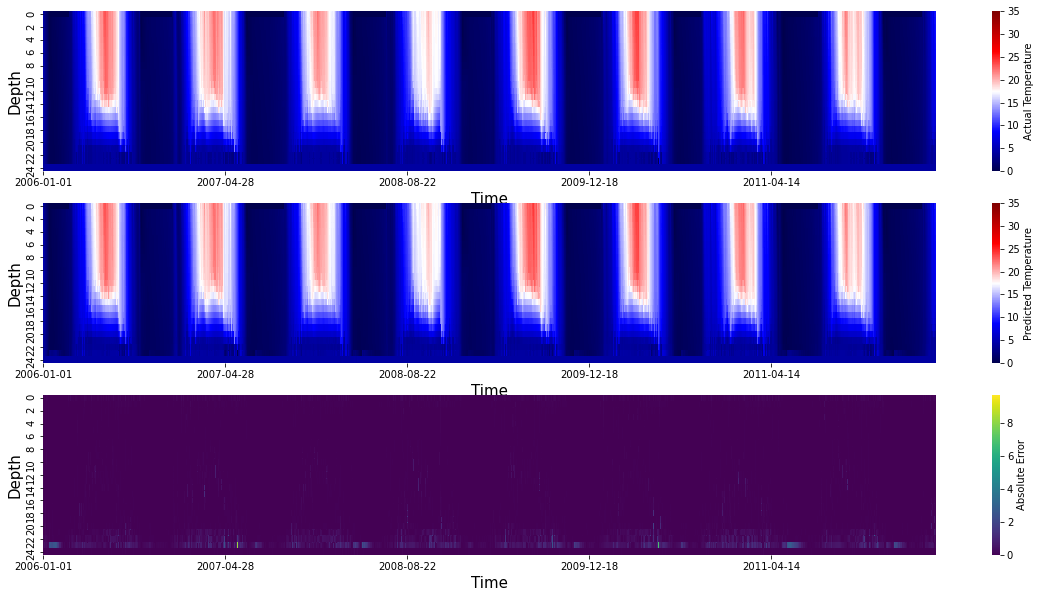

In [29]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

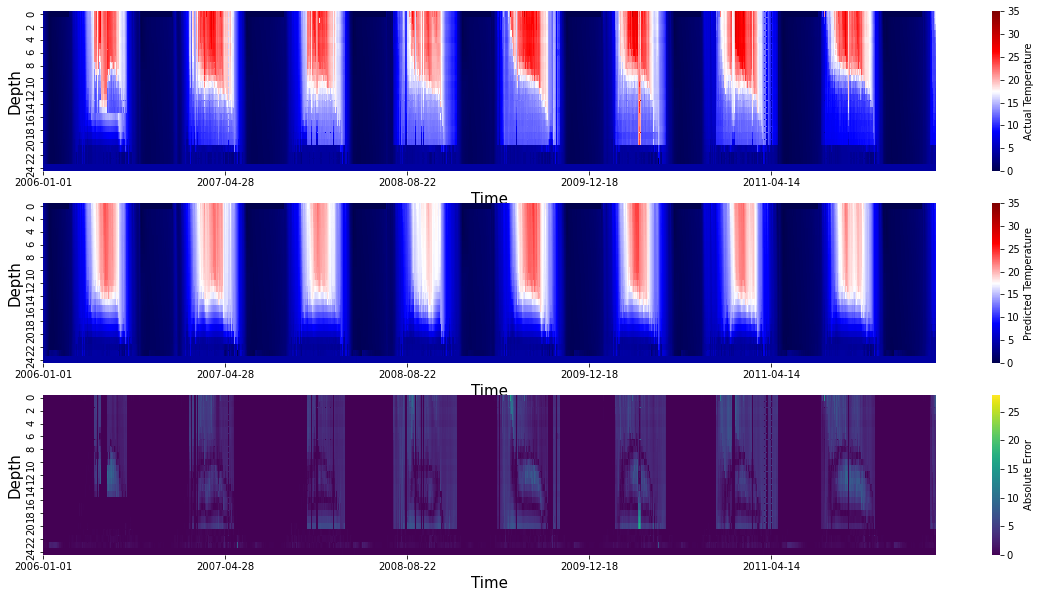

In [30]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [31]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model,heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.00040685644
RMSE of after m1 0.70851576
RMSE of after m2 0.7160733
RMSE of after m3 0.103591636
RMSE of after m4 0.10361398
RMSE of after m0 0.00038437784
RMSE of after m1 0.6898497
RMSE of after m2 0.6977635
RMSE of after m3 0.099296585
RMSE of after m4 0.099304296
RMSE of after m0 0.0004228058
RMSE of after m1 0.67883325
RMSE of after m2 0.68519497
RMSE of after m3 0.11355666
RMSE of after m4 0.113571346
RMSE of after m0 0.00046273702
RMSE of after m1 0.68441147
RMSE of after m2 0.69334203
RMSE of after m3 0.11508511
RMSE of after m4 0.11509195
RMSE of after m0 0.00039467865
RMSE of after m1 0.6994464
RMSE of after m2 0.7012198
RMSE of after m3 0.13000344
RMSE of after m4 0.13002227
RMSE of after m0 0.00052658113
RMSE of after m1 0.6667265
RMSE of after m2 0.671066
RMSE of after m3 0.14363116
RMSE of after m4 0.14364527
RMSE of after m0 0.0005018738
RMSE of after m1 0.6667033
RMSE of after m2 0.6747566
RMSE of after m3 0.11056684
RMSE of after m4 0.11057827
RMSE of

RMSE of after m0 0.0009117057
RMSE of after m1 0.9132097
RMSE of after m2 0.92722094
RMSE of after m3 0.28197974
RMSE of after m4 0.28197023
RMSE of after m0 0.000834609
RMSE of after m1 0.6769956
RMSE of after m2 0.7212309
RMSE of after m3 0.29365334
RMSE of after m4 0.2936972
RMSE of after m0 0.0007458262
RMSE of after m1 0.7805791
RMSE of after m2 0.7895983
RMSE of after m3 0.27033344
RMSE of after m4 0.2703615
RMSE of after m0 0.00064581033
RMSE of after m1 0.5800387
RMSE of after m2 0.5829451
RMSE of after m3 0.10329721
RMSE of after m4 0.10343119
RMSE of after m0 0.0005992616
RMSE of after m1 0.5151384
RMSE of after m2 0.5041563
RMSE of after m3 0.15329476
RMSE of after m4 0.15334094
RMSE of after m0 0.0004975277
RMSE of after m1 0.61829543
RMSE of after m2 0.6315713
RMSE of after m3 0.23564047
RMSE of after m4 0.23570068
RMSE of after m0 0.00053268106
RMSE of after m1 0.6004156
RMSE of after m2 0.60589767
RMSE of after m3 0.104151
RMSE of after m4 0.104325645
RMSE of after m0 0.

RMSE of after m0 0.00024307743
RMSE of after m1 0.14083096
RMSE of after m2 0.14502168
RMSE of after m3 0.1912017
RMSE of after m4 0.1911426
RMSE of after m0 0.00023307081
RMSE of after m1 0.14411353
RMSE of after m2 0.14691491
RMSE of after m3 0.18223813
RMSE of after m4 0.18220825
RMSE of after m0 0.00023502254
RMSE of after m1 0.14706385
RMSE of after m2 0.14677191
RMSE of after m3 0.17567676
RMSE of after m4 0.17572613
RMSE of after m0 0.00023684384
RMSE of after m1 0.15057436
RMSE of after m2 0.1538121
RMSE of after m3 0.13928895
RMSE of after m4 0.13925575
RMSE of after m0 0.00027293427
RMSE of after m1 0.15247355
RMSE of after m2 0.15620068
RMSE of after m3 0.13217698
RMSE of after m4 0.13212387
RMSE of after m0 0.000249106
RMSE of after m1 0.15319131
RMSE of after m2 0.15565193
RMSE of after m3 0.13058974
RMSE of after m4 0.13059272
RMSE of after m0 0.00022930278
RMSE of after m1 0.15674305
RMSE of after m2 0.1580131
RMSE of after m3 0.11407376
RMSE of after m4 0.11408181
RMSE 

RMSE of after m0 0.00019731265
RMSE of after m1 0.68454784
RMSE of after m2 0.59080935
RMSE of after m3 0.08740917
RMSE of after m4 0.08744977
RMSE of after m0 0.0002011479
RMSE of after m1 0.71558386
RMSE of after m2 0.55071974
RMSE of after m3 0.088320374
RMSE of after m4 0.088366345
RMSE of after m0 0.00032128973
RMSE of after m1 0.7300616
RMSE of after m2 0.5713593
RMSE of after m3 0.10582348
RMSE of after m4 0.10584483
RMSE of after m0 0.00021756603
RMSE of after m1 0.7191739
RMSE of after m2 0.61547333
RMSE of after m3 0.11089023
RMSE of after m4 0.11093538
RMSE of after m0 0.0003636546
RMSE of after m1 0.77121246
RMSE of after m2 0.5748535
RMSE of after m3 0.14262335
RMSE of after m4 0.14263773
RMSE of after m0 0.0003099425
RMSE of after m1 0.6887241
RMSE of after m2 0.6936
RMSE of after m3 0.10146039
RMSE of after m4 0.10151404
RMSE of after m0 0.00027368215
RMSE of after m1 0.7541113
RMSE of after m2 0.6853275
RMSE of after m3 0.1703335
RMSE of after m4 0.17036988
RMSE of afte

RMSE of after m4 0.3170561
RMSE of after m0 0.0013869752
RMSE of after m1 0.6490114
RMSE of after m2 0.6479831
RMSE of after m3 0.29501304
RMSE of after m4 0.29507422
RMSE of after m0 0.001331077
RMSE of after m1 0.6123113
RMSE of after m2 0.6205967
RMSE of after m3 0.32102582
RMSE of after m4 0.32110652
RMSE of after m0 0.0014541185
RMSE of after m1 0.5000602
RMSE of after m2 0.5231377
RMSE of after m3 0.31680965
RMSE of after m4 0.3169154
RMSE of after m0 0.0012510242
RMSE of after m1 0.512764
RMSE of after m2 0.4993692
RMSE of after m3 0.25333285
RMSE of after m4 0.2534341
RMSE of after m0 0.0010720354
RMSE of after m1 0.56635964
RMSE of after m2 0.5560422
RMSE of after m3 0.28926384
RMSE of after m4 0.28934875
RMSE of after m0 0.0010002947
RMSE of after m1 0.55210906
RMSE of after m2 0.53639126
RMSE of after m3 0.25935155
RMSE of after m4 0.2594271
RMSE of after m0 0.00091236475
RMSE of after m1 0.5185755
RMSE of after m2 0.49573022
RMSE of after m3 0.18813267
RMSE of after m4 0.18

RMSE of after m1 0.46391138
RMSE of after m2 0.059618
RMSE of after m3 0.049082424
RMSE of after m4 0.048997372
RMSE of after m0 0.00025131463
RMSE of after m1 0.4424057
RMSE of after m2 0.11494532
RMSE of after m3 0.05256179
RMSE of after m4 0.05238181
RMSE of after m0 0.00030489377
RMSE of after m1 0.3642295
RMSE of after m2 0.22029355
RMSE of after m3 0.04437101
RMSE of after m4 0.044500664
RMSE of after m0 0.00031616076
RMSE of after m1 0.2773609
RMSE of after m2 0.2724845
RMSE of after m3 0.033042543
RMSE of after m4 0.032713972
RMSE of after m0 0.000375047
RMSE of after m1 0.22747587
RMSE of after m2 0.15246047
RMSE of after m3 0.09244335
RMSE of after m4 0.092473164
RMSE of after m0 0.00029385684
RMSE of after m1 0.21971612
RMSE of after m2 0.20670508
RMSE of after m3 0.04306263
RMSE of after m4 0.042880114
RMSE of after m0 0.00033640227
RMSE of after m1 0.20194729
RMSE of after m2 0.13065608
RMSE of after m3 0.080598444
RMSE of after m4 0.08071332
RMSE of after m0 0.00033470042

RMSE of after m1 0.38491678
RMSE of after m2 0.20969738
RMSE of after m3 0.06143367
RMSE of after m4 0.061534945
RMSE of after m0 0.0002816901
RMSE of after m1 0.36079472
RMSE of after m2 0.25217864
RMSE of after m3 0.042092863
RMSE of after m4 0.0423909
RMSE of after m0 0.00027856595
RMSE of after m1 0.34354752
RMSE of after m2 0.20972839
RMSE of after m3 0.04075101
RMSE of after m4 0.04101284
RMSE of after m0 0.00026130176
RMSE of after m1 0.3313804
RMSE of after m2 0.18089586
RMSE of after m3 0.050488573
RMSE of after m4 0.050586674
RMSE of after m0 0.00032754152
RMSE of after m1 0.31294617
RMSE of after m2 0.19914137
RMSE of after m3 0.052908655
RMSE of after m4 0.05312132
RMSE of after m0 0.00030602168
RMSE of after m1 0.2819599
RMSE of after m2 0.23794909
RMSE of after m3 0.07916769
RMSE of after m4 0.079386175
RMSE of after m0 0.0003054545
RMSE of after m1 0.275325
RMSE of after m2 0.25395525
RMSE of after m3 0.07710891
RMSE of after m4 0.077357076
RMSE of after m0 0.00032914305

RMSE of after m0 0.0010154907
RMSE of after m1 0.73929167
RMSE of after m2 0.7451593
RMSE of after m3 0.10525578
RMSE of after m4 0.105286404
RMSE of after m0 0.00094662263
RMSE of after m1 0.7555606
RMSE of after m2 0.76270175
RMSE of after m3 0.10009434
RMSE of after m4 0.10011127
RMSE of after m0 0.0009321348
RMSE of after m1 0.75937355
RMSE of after m2 0.7683598
RMSE of after m3 0.10683933
RMSE of after m4 0.10684613
RMSE of after m0 0.0008865133
RMSE of after m1 0.75084126
RMSE of after m2 0.76012284
RMSE of after m3 0.13192753
RMSE of after m4 0.1319227
RMSE of after m0 0.0011332788
RMSE of after m1 0.75664574
RMSE of after m2 0.76311946
RMSE of after m3 0.109615974
RMSE of after m4 0.10963559
RMSE of after m0 0.0011258477
RMSE of after m1 0.7690775
RMSE of after m2 0.7765836
RMSE of after m3 0.07966255
RMSE of after m4 0.07966541
RMSE of after m0 0.0011877355
RMSE of after m1 0.7654396
RMSE of after m2 0.7709364
RMSE of after m3 0.075536005
RMSE of after m4 0.07552988
RMSE of af

RMSE of after m4 0.18529263
RMSE of after m0 0.0007421092
RMSE of after m1 0.51138157
RMSE of after m2 0.51054406
RMSE of after m3 0.14702974
RMSE of after m4 0.14706193
RMSE of after m0 0.0006314639
RMSE of after m1 0.5507932
RMSE of after m2 0.59123284
RMSE of after m3 0.21638831
RMSE of after m4 0.21643412
RMSE of after m0 0.0005785198
RMSE of after m1 0.5669965
RMSE of after m2 0.7677493
RMSE of after m3 0.6761517
RMSE of after m4 0.67509776
RMSE of after m0 0.00060908776
RMSE of after m1 0.7764167
RMSE of after m2 0.7912029
RMSE of after m3 0.13503467
RMSE of after m4 0.13509773
RMSE of after m0 0.0005951515
RMSE of after m1 0.5308839
RMSE of after m2 0.8824305
RMSE of after m3 0.7286457
RMSE of after m4 0.7286236
RMSE of after m0 0.0005397007
RMSE of after m1 0.7144849
RMSE of after m2 0.729961
RMSE of after m3 0.12013194
RMSE of after m4 0.12021546
RMSE of after m0 0.0005841873
RMSE of after m1 0.59599876
RMSE of after m2 0.6200417
RMSE of after m3 0.21050891
RMSE of after m4 0.

RMSE of after m0 0.00026347974
RMSE of after m1 0.22042932
RMSE of after m2 0.22176282
RMSE of after m3 0.037175145
RMSE of after m4 0.03658738
RMSE of after m0 0.00023520838
RMSE of after m1 0.22635369
RMSE of after m2 0.22740328
RMSE of after m3 0.037513427
RMSE of after m4 0.037030462
RMSE of after m0 0.00024159405
RMSE of after m1 0.23156604
RMSE of after m2 0.23356116
RMSE of after m3 0.03705524
RMSE of after m4 0.0366638
RMSE of after m0 0.0002855918
RMSE of after m1 0.23616263
RMSE of after m2 0.23910126
RMSE of after m3 0.035093635
RMSE of after m4 0.03482889
RMSE of after m0 0.0003927271
RMSE of after m1 0.24281272
RMSE of after m2 0.24180292
RMSE of after m3 0.0358912
RMSE of after m4 0.0361648
RMSE of after m0 0.00030162354
RMSE of after m1 0.24970295
RMSE of after m2 0.24906388
RMSE of after m3 0.032758493
RMSE of after m4 0.03277043
RMSE of after m0 0.00025911274
RMSE of after m1 0.25451759
RMSE of after m2 0.25712666
RMSE of after m3 0.024258763
RMSE of after m4 0.0237060

RMSE of after m1 0.6119775
RMSE of after m2 0.6173076
RMSE of after m3 0.12578766
RMSE of after m4 0.12579629
RMSE of after m0 0.00051468576
RMSE of after m1 0.7566432
RMSE of after m2 0.8024463
RMSE of after m3 0.24503955
RMSE of after m4 0.24508698
RMSE of after m0 0.00061361596
RMSE of after m1 0.6087958
RMSE of after m2 0.6023596
RMSE of after m3 0.21827008
RMSE of after m4 0.2182933
RMSE of after m0 0.00053879013
RMSE of after m1 0.703578
RMSE of after m2 0.71151024
RMSE of after m3 0.23159729
RMSE of after m4 0.2316227
RMSE of after m0 0.00068626105
RMSE of after m1 0.749025
RMSE of after m2 0.75826883
RMSE of after m3 0.17028217
RMSE of after m4 0.17030475
RMSE of after m0 0.0008456246
RMSE of after m1 0.7883959
RMSE of after m2 0.7966278
RMSE of after m3 0.106346704
RMSE of after m4 0.10638683
RMSE of after m0 0.0009508374
RMSE of after m1 0.767734
RMSE of after m2 0.78249204
RMSE of after m3 0.12595662
RMSE of after m4 0.12597285
RMSE of after m0 0.0008955489
RMSE of after m1 

RMSE of after m0 0.00080192444
RMSE of after m1 0.7431024
RMSE of after m2 0.74780244
RMSE of after m3 0.1938336
RMSE of after m4 0.19388999
RMSE of after m0 0.0008997405
RMSE of after m1 0.7648125
RMSE of after m2 0.7678063
RMSE of after m3 0.16903803
RMSE of after m4 0.16910526
RMSE of after m0 0.00083010347
RMSE of after m1 0.7546847
RMSE of after m2 0.7697097
RMSE of after m3 0.21040522
RMSE of after m4 0.21045347
RMSE of after m0 0.00080781477
RMSE of after m1 0.7524129
RMSE of after m2 0.7591906
RMSE of after m3 0.18233822
RMSE of after m4 0.18240643
RMSE of after m0 0.0008626612
RMSE of after m1 0.7657062
RMSE of after m2 0.7682197
RMSE of after m3 0.18029618
RMSE of after m4 0.18036439
RMSE of after m0 0.0009469482
RMSE of after m1 0.7638589
RMSE of after m2 0.76648015
RMSE of after m3 0.18364024
RMSE of after m4 0.1837014
RMSE of after m0 0.001017723
RMSE of after m1 0.753105
RMSE of after m2 0.7615769
RMSE of after m3 0.19611841
RMSE of after m4 0.1961752
RMSE of after m0 0.0

RMSE of after m2 0.1649109
RMSE of after m3 0.098519
RMSE of after m4 0.09632597
RMSE of after m0 0.00030256176
RMSE of after m1 0.16261767
RMSE of after m2 0.17080054
RMSE of after m3 0.082192905
RMSE of after m4 0.0791746
RMSE of after m0 0.00028381142
RMSE of after m1 0.16477555
RMSE of after m2 0.16847138
RMSE of after m3 0.07676802
RMSE of after m4 0.07472888
RMSE of after m0 0.0002539078
RMSE of after m1 0.16642274
RMSE of after m2 0.17480382
RMSE of after m3 0.069111355
RMSE of after m4 0.06590023
RMSE of after m0 0.0003044916
RMSE of after m1 0.16975014
RMSE of after m2 0.17435662
RMSE of after m3 0.060210396
RMSE of after m4 0.05766084
RMSE of after m0 0.00023267967
RMSE of after m1 0.17374529
RMSE of after m2 0.18020348
RMSE of after m3 0.04556402
RMSE of after m4 0.042595185
RMSE of after m0 0.00025326706
RMSE of after m1 0.1772245
RMSE of after m2 0.18210939
RMSE of after m3 0.041619428
RMSE of after m4 0.03807103
RMSE of after m0 0.00025438145
RMSE of after m1 0.18095687
R

RMSE of after m3 0.04380027
RMSE of after m4 0.043912385
RMSE of after m0 0.0002603988
RMSE of after m1 0.39428946
RMSE of after m2 0.18817231
RMSE of after m3 0.042412803
RMSE of after m4 0.042494122
RMSE of after m0 0.00029664152
RMSE of after m1 0.42099968
RMSE of after m2 0.31215978
RMSE of after m3 0.054857347
RMSE of after m4 0.05492947
RMSE of after m0 0.00047447864
RMSE of after m1 0.4816683
RMSE of after m2 0.13291511
RMSE of after m3 0.08682806
RMSE of after m4 0.086890444
RMSE of after m0 0.00028504693
RMSE of after m1 0.55547065
RMSE of after m2 0.47628468
RMSE of after m3 0.09759373
RMSE of after m4 0.09769283
RMSE of after m0 0.00027747249
RMSE of after m1 0.6360331
RMSE of after m2 0.5057846
RMSE of after m3 0.09506403
RMSE of after m4 0.095123045
RMSE of after m0 0.00023012853
RMSE of after m1 0.6883456
RMSE of after m2 0.6004246
RMSE of after m3 0.094242826
RMSE of after m4 0.094292335
RMSE of after m0 0.0002244937
RMSE of after m1 0.7319667
RMSE of after m2 0.6791822


RMSE of after m0 0.0010855709
RMSE of after m1 0.763876
RMSE of after m2 0.7698386
RMSE of after m3 0.07357527
RMSE of after m4 0.07358136
RMSE of after m0 0.0011778277
RMSE of after m1 0.76257515
RMSE of after m2 0.77526915
RMSE of after m3 0.12057492
RMSE of after m4 0.12059329
RMSE of after m0 0.0010514153
RMSE of after m1 0.75849384
RMSE of after m2 0.76359403
RMSE of after m3 0.07466441
RMSE of after m4 0.07472813
RMSE of after m0 0.0010405666
RMSE of after m1 0.75546664
RMSE of after m2 0.76123595
RMSE of after m3 0.07471088
RMSE of after m4 0.07473213
RMSE of after m0 0.0010745935
RMSE of after m1 0.75682276
RMSE of after m2 0.76326865
RMSE of after m3 0.07767761
RMSE of after m4 0.077704415
RMSE of after m0 0.0011018232
RMSE of after m1 0.7592668
RMSE of after m2 0.7635938
RMSE of after m3 0.07284438
RMSE of after m4 0.07286704
RMSE of after m0 0.0010516788
RMSE of after m1 0.75953245
RMSE of after m2 0.764562
RMSE of after m3 0.07630501
RMSE of after m4 0.07630968
RMSE of afte

RMSE of after m1 0.67306715
RMSE of after m2 0.5408155
RMSE of after m3 0.09643179
RMSE of after m4 0.09651819
RMSE of after m0 0.00021871374
RMSE of after m1 0.5775551
RMSE of after m2 0.5635378
RMSE of after m3 0.1050331
RMSE of after m4 0.10507994
RMSE of after m0 0.00024929747
RMSE of after m1 0.5107659
RMSE of after m2 0.51220274
RMSE of after m3 0.10849285
RMSE of after m4 0.108499646
RMSE of after m0 0.00027655263
RMSE of after m1 0.44057214
RMSE of after m2 0.385928
RMSE of after m3 0.13016735
RMSE of after m4 0.1301539
RMSE of after m0 0.00028730303
RMSE of after m1 0.36551526
RMSE of after m2 0.31671712
RMSE of after m3 0.17576747
RMSE of after m4 0.17571647
RMSE of after m0 0.00027928452
RMSE of after m1 0.30006182
RMSE of after m2 0.25907195
RMSE of after m3 0.18632677
RMSE of after m4 0.18628916
RMSE of after m0 0.00029503505
RMSE of after m1 0.27100995
RMSE of after m2 0.2503759
RMSE of after m3 0.239075
RMSE of after m4 0.23904921
RMSE of after m0 0.00034459375
RMSE of a

RMSE of after m0 0.00023701324
RMSE of after m1 0.22900775
RMSE of after m2 0.23087527
RMSE of after m3 0.039189644
RMSE of after m4 0.039069194
RMSE of after m0 0.00031417105
RMSE of after m1 0.23114584
RMSE of after m2 0.23912328
RMSE of after m3 0.05476009
RMSE of after m4 0.05304202
RMSE of after m0 0.00044793016
RMSE of after m1 0.23351042
RMSE of after m2 0.23915333
RMSE of after m3 0.046643224
RMSE of after m4 0.044585437
RMSE of after m0 0.00029408143
RMSE of after m1 0.23403695
RMSE of after m2 0.23579982
RMSE of after m3 0.03838329
RMSE of after m4 0.038045213
RMSE of after m0 0.0003236747
RMSE of after m1 0.2372579
RMSE of after m2 0.23953278
RMSE of after m3 0.03558907
RMSE of after m4 0.03519724
RMSE of after m0 0.00026157944
RMSE of after m1 0.24266207
RMSE of after m2 0.24462847
RMSE of after m3 0.03445733
RMSE of after m4 0.034311336
RMSE of after m0 0.0005271493
RMSE of after m1 0.24818474
RMSE of after m2 0.24983083
RMSE of after m3 0.034760203
RMSE of after m4 0.0331

RMSE of after m1 0.6873703
RMSE of after m2 0.7062023
RMSE of after m3 0.19214073
RMSE of after m4 0.19214769
RMSE of after m0 0.00062990095
RMSE of after m1 0.7304131
RMSE of after m2 0.74209684
RMSE of after m3 0.12759751
RMSE of after m4 0.1276206
RMSE of after m0 0.0006947615
RMSE of after m1 0.7138016
RMSE of after m2 0.7378651
RMSE of after m3 0.1884075
RMSE of after m4 0.18839641
RMSE of after m0 0.00051998557
RMSE of after m1 0.5737246
RMSE of after m2 0.5642461
RMSE of after m3 0.19830364
RMSE of after m4 0.19832349
RMSE of after m0 0.0006170296
RMSE of after m1 0.6933364
RMSE of after m2 0.6976525
RMSE of after m3 0.2203684
RMSE of after m4 0.22038542
RMSE of after m0 0.0005855593
RMSE of after m1 0.74786335
RMSE of after m2 0.75483006
RMSE of after m3 0.16533928
RMSE of after m4 0.1653539
RMSE of after m0 0.0006301358
RMSE of after m1 0.7805972
RMSE of after m2 0.7847293
RMSE of after m3 0.104743764
RMSE of after m4 0.10475504
RMSE of after m0 0.00068816077
RMSE of after m1 

RMSE of after m0 0.0011451952
RMSE of after m1 0.5989291
RMSE of after m2 0.5998508
RMSE of after m3 0.2507088
RMSE of after m4 0.2507241
RMSE of after m0 0.0010911239
RMSE of after m1 0.5250118
RMSE of after m2 0.51356614
RMSE of after m3 0.19194041
RMSE of after m4 0.19193992
RMSE of after m0 0.0009989311
RMSE of after m1 0.46672153
RMSE of after m2 0.43240392
RMSE of after m3 0.083164774
RMSE of after m4 0.08314076
RMSE of after m0 0.000864926
RMSE of after m1 0.4964536
RMSE of after m2 0.467495
RMSE of after m3 0.16756797
RMSE of after m4 0.16756333
RMSE of after m0 0.0012884508
RMSE of after m1 0.5655521
RMSE of after m2 0.6831619
RMSE of after m3 0.45763338
RMSE of after m4 0.45763135
RMSE of after m0 0.0009696651
RMSE of after m1 0.8014044
RMSE of after m2 0.8444628
RMSE of after m3 0.36074197
RMSE of after m4 0.3607373
RMSE of after m0 0.00082187395
RMSE of after m1 0.7241516
RMSE of after m2 0.73482525
RMSE of after m3 0.15257226
RMSE of after m4 0.15260847
RMSE of after m0 0.

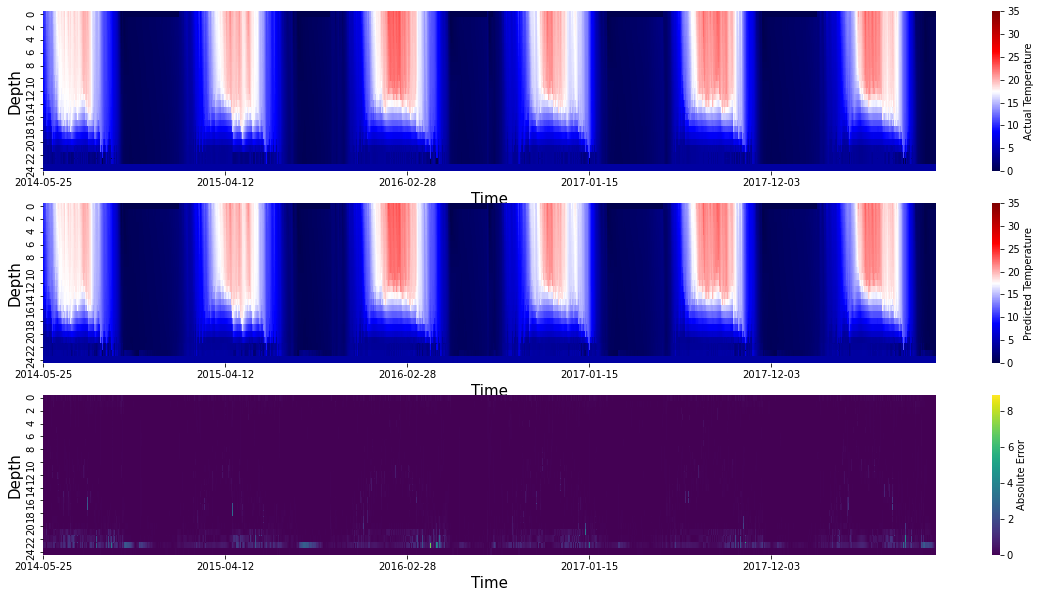

In [32]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

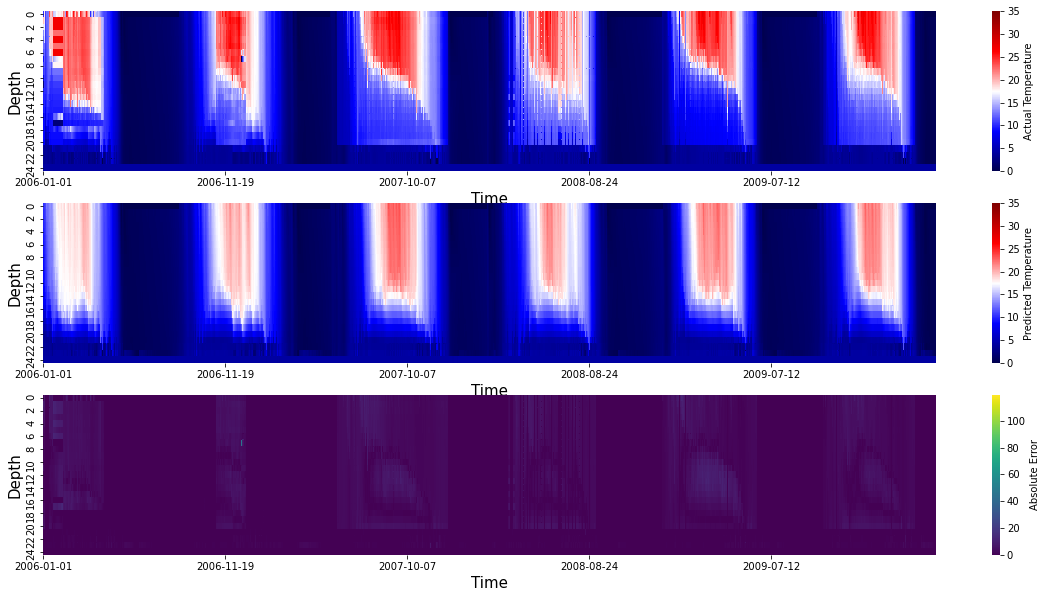

In [33]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [34]:
train_rmse, train_l2_err = compute_metrics( heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 11.395342155022304, Train L2 Error: 1.1868947968576393
Test RMSE: 12.028427025260507, Train L2 Error: 1.1740138800862012


## Mixing Model

In [35]:
train_rmse, train_l2_err = compute_metrics(mixing_model, train_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(mixing_model, test_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.11018267930181727, Train L2 Error: 0.011469719278175432
Test RMSE: 0.121947361205087, Train L2 Error: 0.011897466396861693


## Convection Model

In [36]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.10238946186873105, Train L2 Error: 0.010641804283639112
Test RMSE: 0.11916663876987295, Train L2 Error: 0.011609599613482435


## Ice Model

In [37]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.0011646093493033137, Train L2 Error: 0.00012104342580499258
Test RMSE: 0.0022081818962783406, Train L2 Error: 0.00021512855883762218


# Finetuning

In [38]:
lr = 1e-5
# decay_rate = 0.1
# decay_steps = 500

params = list(heating_model.parameters()) + list(heat_diff_model.parameters()) + list(mixing_model.parameters()) + list(convection_model.parameters()) + list(ice_model.parameters())

optimizer = torch.optim.Adam(params, lr=lr, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

# Freeze model weights

In [39]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [40]:
#freeze_model(heating_model)
freeze_model(heating_model)
freeze_model(heat_diff_model)
unfreeze_model(mixing_model)
freeze_model(convection_model)
freeze_model(ice_model)


# Finetuning on Observed Temperature

In [41]:
heating_model.train()
heat_diff_model.train()
mixing_model.train()
convection_model.train()
ice_model.train()

n_epochs = 500

# mean and standard dev of "temp_total04" of model 4 output
mean_out4 = torch.tensor(train_mean[m4_output_column_ix[0]]).float().to(device)
std_out4 = torch.tensor(train_std[m4_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input
m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

train_loss = []
LOSS_m0 = []
LOSS_m1 = []
LOSS_m2 = []
LOSS_m3 = []
LOSS_m4 = []

for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    loss_epoch_m0 = 0
    loss_epoch_m1 = 0
    loss_epoch_m2 = 0
    loss_epoch_m3 = 0
    loss_epoch_m4 = 0
    for ix, x in enumerate(iter(train_loader)):
        x = x.to(device).float()
        optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
        m0_input = x[:, m0_input_column_ix]
        
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
        loss_m0 = criterion(m0_pred, x[:, m0_output_column_ix])

        #model 1
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m0_pred], dim=-1)
        # m1_pred = heat_diff_model(m1_input)
        
        proj = heat_diff_model(m1_input)
        pred = implicit_diffusion(proj, m0_pred)        
        m1_pred = pred.to(dtype=torch.float32)
                
        loss_m1 = criterion(m1_pred, x[:, m1_output_column_ix])
        
        #m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        #m1_pred_temp = m1_pred[:,1:2]
            
        #loss_m1 = criterion(m1_pred_temp, x[:, m1_output_column_ix[1]].unsqueeze(1))

        #model 2
        m2_input = torch.cat([x[:, m2_input_column_ix[:-1]], m1_pred], dim=-1)
        m2_pred = mixing_model(m2_input)
            
        loss_m2 = criterion(m2_pred, x[:, m2_output_column_ix])

        #model 3
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m2_pred], dim=-1)
        m3_pred = convection_model(m3_input)

        loss_m3 = criterion(m3_pred, x[:, m3_output_column_ix])

        #model 4
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m3_pred], dim=-1)
        m4_pred = ice_model(m4_input)
        
        obs_temp_true = x[:, obs_temp_columns_ix] * std_obs + mean_obs
        obs_temp_true_norm = (obs_temp_true - mean_out4)/std_out4
        
        loss_m4 = criterion(m4_pred, obs_temp_true_norm)

        #loss = (loss_m0 + loss_m1 + loss_m2 + loss_m3 + loss_m4)
        
        loss = loss_m4
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        loss_epoch_m0 += loss_m0.item()
        loss_epoch_m1 += loss_m1.item()
        loss_epoch_m2 += loss_m2.item()
        loss_epoch_m3 += loss_m3.item()
        loss_epoch_m4 += loss_m4.item()
    
    loss_epoch = loss_epoch/len(train_loader)
    loss_epoch_m0 = loss_epoch_m0/len(train_loader)
    loss_epoch_m1 = loss_epoch_m1/len(train_loader)
    loss_epoch_m2 = loss_epoch_m2/len(train_loader)
    loss_epoch_m3 = loss_epoch_m3/len(train_loader)
    loss_epoch_m4 = loss_epoch_m4/len(train_loader)
    
    train_loss.append(loss_epoch)
    LOSS_m0.append(loss_epoch_m0)
    LOSS_m1.append(loss_epoch_m1)
    LOSS_m2.append(loss_epoch_m2)
    LOSS_m3.append(loss_epoch_m3)
    LOSS_m4.append(loss_epoch_m4)
    if it % 50 == 0:
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Loss m0: {LOSS_m0[-1]}, Loss m1: {LOSS_m1[-1]}, Loss m2: {LOSS_m2[-1]}, Loss m3: {LOSS_m3[-1]}, Loss m4: {LOSS_m4[-1]}")
    
    #plot the loss_m1, m2


  0%|          | 1/500 [00:22<3:04:23, 22.17s/it]

Epoch : 0, Train_loss: 0.09828472255806943, Loss m0: 1.01546296352897e-08, Loss m1: 0.008266773895949249, Loss m2: 0.012468683457657039, Loss m3: 0.005920691797241093, Loss m4: 0.09828472255806943


 10%|█         | 51/500 [19:06<2:55:26, 23.44s/it]

Epoch : 50, Train_loss: 0.04720952663803631, Loss m0: 1.01546296352897e-08, Loss m1: 0.008266773895949249, Loss m2: 0.06386370191574552, Loss m3: 0.05877017027579986, Loss m4: 0.04720952663803631


 20%|██        | 101/500 [38:01<2:28:09, 22.28s/it]

Epoch : 100, Train_loss: 0.044955593968479264, Loss m0: 1.01546296352897e-08, Loss m1: 0.008266773895949249, Loss m2: 0.06995322460187826, Loss m3: 0.06616213152292205, Loss m4: 0.044955593968479264


 30%|███       | 151/500 [53:52<2:10:00, 22.35s/it]

Epoch : 150, Train_loss: 0.0444468973188004, Loss m0: 1.01546296352897e-08, Loss m1: 0.008266773895949249, Loss m2: 0.0711393125352713, Loss m3: 0.0678344356694276, Loss m4: 0.0444468973188004


 40%|████      | 201/500 [1:12:39<1:51:37, 22.40s/it]

Epoch : 200, Train_loss: 0.044135850601951854, Loss m0: 1.01546296352897e-08, Loss m1: 0.008266773895949249, Loss m2: 0.07141718252471195, Loss m3: 0.06832994844440968, Loss m4: 0.044135850601951854


 50%|█████     | 251/500 [1:31:22<1:34:20, 22.73s/it]

Epoch : 250, Train_loss: 0.04390112330736923, Loss m0: 1.01546296352897e-08, Loss m1: 0.008266773895949249, Loss m2: 0.07152496731595538, Loss m3: 0.06847839771540036, Loss m4: 0.04390112330736923


 60%|██████    | 301/500 [1:50:07<1:14:18, 22.40s/it]

Epoch : 300, Train_loss: 0.043714959684308746, Loss m0: 1.01546296352897e-08, Loss m1: 0.008266773895949249, Loss m2: 0.07158537449172202, Loss m3: 0.06865121019693858, Loss m4: 0.043714959684308746


 70%|███████   | 351/500 [2:09:17<55:12, 22.23s/it]  

Epoch : 350, Train_loss: 0.04355879707442771, Loss m0: 1.01546296352897e-08, Loss m1: 0.008266773895949249, Loss m2: 0.07161311690174246, Loss m3: 0.06874225264627572, Loss m4: 0.04355879707442771


 80%|████████  | 401/500 [2:28:05<37:04, 22.47s/it]

Epoch : 400, Train_loss: 0.04342219038738953, Loss m0: 1.01546296352897e-08, Loss m1: 0.008266773895949249, Loss m2: 0.07161634399131087, Loss m3: 0.06888130127284592, Loss m4: 0.04342219038738953


 90%|█████████ | 451/500 [2:46:55<18:20, 22.45s/it]

Epoch : 450, Train_loss: 0.04330043934821195, Loss m0: 1.01546296352897e-08, Loss m1: 0.008266773895949249, Loss m2: 0.07157796879971853, Loss m3: 0.06903763644326734, Loss m4: 0.04330043934821195


100%|██████████| 500/500 [3:05:22<00:00, 22.24s/it]


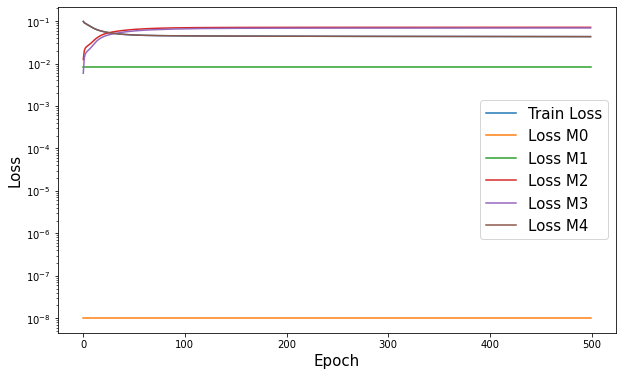

In [42]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label = "Train Loss")
plt.plot(LOSS_m0, label = "Loss M0")
plt.plot(LOSS_m1, label = "Loss M1")
plt.plot(LOSS_m2, label = "Loss M2")
plt.plot(LOSS_m3, label = "Loss M3")
plt.plot(LOSS_m4, label = "Loss M4")
plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)
plt.show()

In [43]:
PATH = f"./saved_models/mixing_model_finetuned.pth"
torch.save(mixing_model.state_dict(), PATH)

# Rollout Evaluation After FineTuning

In [44]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.00029189952
RMSE of after m1 0.8203211
RMSE of after m2 0.66524684
RMSE of after m3 0.558299
RMSE of after m4 0.5588477
RMSE of after m0 0.0002657973
RMSE of after m1 0.7427424
RMSE of after m2 0.76453274
RMSE of after m3 0.43618584
RMSE of after m4 0.43657136
RMSE of after m0 0.0002682778
RMSE of after m1 0.73037225
RMSE of after m2 0.3204833
RMSE of after m3 0.2795301
RMSE of after m4 0.27971223
RMSE of after m0 0.00026245267
RMSE of after m1 0.7214254
RMSE of after m2 0.52669466
RMSE of after m3 0.20923659
RMSE of after m4 0.21017615
RMSE of after m0 0.00025182773
RMSE of after m1 0.6361745
RMSE of after m2 0.46692958
RMSE of after m3 0.18586516
RMSE of after m4 0.18674815
RMSE of after m0 0.00023454186
RMSE of after m1 0.57111347
RMSE of after m2 0.47064933
RMSE of after m3 0.15302272
RMSE of after m4 0.1536303
RMSE of after m0 0.00024618732
RMSE of after m1 0.50591993
RMSE of after m2 0.4331698
RMSE of after m3 0.17447872
RMSE of after m4 0.1746886
RMSE of after

RMSE of after m0 0.00025584403
RMSE of after m1 0.533454
RMSE of after m2 0.5144889
RMSE of after m3 0.32236916
RMSE of after m4 0.32256612
RMSE of after m0 0.00022138761
RMSE of after m1 0.5958483
RMSE of after m2 0.6318576
RMSE of after m3 0.41311237
RMSE of after m4 0.41340864
RMSE of after m0 0.00023827997
RMSE of after m1 0.6598525
RMSE of after m2 0.47481754
RMSE of after m3 0.44097027
RMSE of after m4 0.4413128
RMSE of after m0 0.0001951756
RMSE of after m1 0.72632116
RMSE of after m2 0.7401459
RMSE of after m3 0.5475101
RMSE of after m4 0.54787284
RMSE of after m0 0.00019981658
RMSE of after m1 0.7329799
RMSE of after m2 0.8497288
RMSE of after m3 0.6441509
RMSE of after m4 0.644484
RMSE of after m0 0.00019617095
RMSE of after m1 0.72469884
RMSE of after m2 0.9161745
RMSE of after m3 0.7327145
RMSE of after m4 0.73301584
RMSE of after m0 0.0001956607
RMSE of after m1 0.7401937
RMSE of after m2 0.980496
RMSE of after m3 0.81574726
RMSE of after m4 0.8159952
RMSE of after m0 0.00

RMSE of after m1 0.7504316
RMSE of after m2 3.0733259
RMSE of after m3 3.0218687
RMSE of after m4 3.0216265
RMSE of after m0 0.0014309122
RMSE of after m1 0.75115705
RMSE of after m2 3.1534152
RMSE of after m3 3.1087458
RMSE of after m4 3.1086311
RMSE of after m0 0.0012145203
RMSE of after m1 0.75021416
RMSE of after m2 3.1363993
RMSE of after m3 3.093957
RMSE of after m4 3.0939193
RMSE of after m0 0.0010310139
RMSE of after m1 0.7428668
RMSE of after m2 2.9975495
RMSE of after m3 2.9569688
RMSE of after m4 2.9569619
RMSE of after m0 0.0011561979
RMSE of after m1 0.73462945
RMSE of after m2 2.921973
RMSE of after m3 2.8771794
RMSE of after m4 2.8771553
RMSE of after m0 0.0012526793
RMSE of after m1 0.7355882
RMSE of after m2 2.8649955
RMSE of after m3 2.817745
RMSE of after m4 2.8177567
RMSE of after m0 0.0012540094
RMSE of after m1 0.73577034
RMSE of after m2 2.8402379
RMSE of after m3 2.7929828
RMSE of after m4 2.793009
RMSE of after m0 0.0010762425
RMSE of after m1 0.7369292
RMSE of

RMSE of after m0 0.00035619567
RMSE of after m1 0.23031871
RMSE of after m2 0.38083652
RMSE of after m3 0.2651446
RMSE of after m4 0.2667642
RMSE of after m0 0.00026554283
RMSE of after m1 0.21978915
RMSE of after m2 0.40589443
RMSE of after m3 0.29856366
RMSE of after m4 0.2997918
RMSE of after m0 0.0002777831
RMSE of after m1 0.21069442
RMSE of after m2 0.34206283
RMSE of after m3 0.21401799
RMSE of after m4 0.21442261
RMSE of after m0 0.0003199012
RMSE of after m1 0.20256981
RMSE of after m2 0.31101635
RMSE of after m3 0.17614144
RMSE of after m4 0.17675805
RMSE of after m0 0.00032488658
RMSE of after m1 0.1954618
RMSE of after m2 0.31381226
RMSE of after m3 0.19150428
RMSE of after m4 0.19221473
RMSE of after m0 0.0003229918
RMSE of after m1 0.18903016
RMSE of after m2 0.28629085
RMSE of after m3 0.15947817
RMSE of after m4 0.16022107
RMSE of after m0 0.00034027558
RMSE of after m1 0.18244591
RMSE of after m2 0.25156274
RMSE of after m3 0.11227724
RMSE of after m4 0.112538524
RMSE 

RMSE of after m0 0.00019018042
RMSE of after m1 0.3493019
RMSE of after m2 0.40706474
RMSE of after m3 0.15078723
RMSE of after m4 0.14062841
RMSE of after m0 0.00028462475
RMSE of after m1 0.35959584
RMSE of after m2 0.42895478
RMSE of after m3 0.17580478
RMSE of after m4 0.16843268
RMSE of after m0 0.0004919375
RMSE of after m1 0.34546453
RMSE of after m2 0.35483563
RMSE of after m3 0.1686841
RMSE of after m4 0.16460015
RMSE of after m0 0.00032369772
RMSE of after m1 0.33812138
RMSE of after m2 0.30613622
RMSE of after m3 0.1464507
RMSE of after m4 0.14680418
RMSE of after m0 0.00066487724
RMSE of after m1 0.45146084
RMSE of after m2 0.25039104
RMSE of after m3 0.17689735
RMSE of after m4 0.17726824
RMSE of after m0 0.0002816248
RMSE of after m1 0.5251805
RMSE of after m2 0.3505269
RMSE of after m3 0.19930974
RMSE of after m4 0.19948974
RMSE of after m0 0.00021496775
RMSE of after m1 0.58108646
RMSE of after m2 0.37784684
RMSE of after m3 0.1993253
RMSE of after m4 0.19943598
RMSE of

RMSE of after m0 0.0012731764
RMSE of after m1 0.7911598
RMSE of after m2 3.0449183
RMSE of after m3 2.9777207
RMSE of after m4 2.977681
RMSE of after m0 0.0014429571
RMSE of after m1 0.77237236
RMSE of after m2 3.202848
RMSE of after m3 3.1461818
RMSE of after m4 3.1462097
RMSE of after m0 0.0013212612
RMSE of after m1 0.74328566
RMSE of after m2 3.165865
RMSE of after m3 3.1164813
RMSE of after m4 3.116528
RMSE of after m0 0.0010278736
RMSE of after m1 0.7253129
RMSE of after m2 3.1426072
RMSE of after m3 3.098534
RMSE of after m4 3.0985494
RMSE of after m0 0.0009390854
RMSE of after m1 0.6974145
RMSE of after m2 3.0120823
RMSE of after m3 2.9676254
RMSE of after m4 2.9676166
RMSE of after m0 0.0012234271
RMSE of after m1 0.7034488
RMSE of after m2 2.9521837
RMSE of after m3 2.9053857
RMSE of after m4 2.9053364
RMSE of after m0 0.0011637161
RMSE of after m1 0.70769703
RMSE of after m2 3.0474672
RMSE of after m3 3.005343
RMSE of after m4 3.005327
RMSE of after m0 0.0011837009
RMSE of 

RMSE of after m2 1.8150223
RMSE of after m3 1.6968024
RMSE of after m4 1.6965126
RMSE of after m0 0.0005940107
RMSE of after m1 0.7603669
RMSE of after m2 1.9233919
RMSE of after m3 1.8880194
RMSE of after m4 1.887692
RMSE of after m0 0.0006682242
RMSE of after m1 0.81850535
RMSE of after m2 1.8572602
RMSE of after m3 2.8128474
RMSE of after m4 1.7815708
RMSE of after m0 0.000606248
RMSE of after m1 0.6963372
RMSE of after m2 1.8546335
RMSE of after m3 1.8968205
RMSE of after m4 1.7686307
RMSE of after m0 0.00048119176
RMSE of after m1 0.6374542
RMSE of after m2 1.8352019
RMSE of after m3 1.7472725
RMSE of after m4 1.7473667
RMSE of after m0 0.00072524534
RMSE of after m1 1.3761672
RMSE of after m2 1.8744832
RMSE of after m3 1.8504161
RMSE of after m4 1.8506536
RMSE of after m0 0.0003724201
RMSE of after m1 0.6998129
RMSE of after m2 1.8102878
RMSE of after m3 1.7155576
RMSE of after m4 1.7160884
RMSE of after m0 0.00029277132
RMSE of after m1 0.7276439
RMSE of after m2 1.8301556
RMSE 

RMSE of after m4 0.07166351
RMSE of after m0 0.0004048632
RMSE of after m1 0.19843262
RMSE of after m2 0.25071946
RMSE of after m3 0.06758479
RMSE of after m4 0.0672345
RMSE of after m0 0.00038389052
RMSE of after m1 0.20210743
RMSE of after m2 0.25199905
RMSE of after m3 0.06374073
RMSE of after m4 0.06342634
RMSE of after m0 0.00048027773
RMSE of after m1 0.20466332
RMSE of after m2 0.25465867
RMSE of after m3 0.061336514
RMSE of after m4 0.06017029
RMSE of after m0 0.00047589067
RMSE of after m1 0.20678875
RMSE of after m2 0.26590362
RMSE of after m3 0.077647775
RMSE of after m4 0.07742551
RMSE of after m0 0.00037092247
RMSE of after m1 0.21058726
RMSE of after m2 0.2678889
RMSE of after m3 0.07232083
RMSE of after m4 0.07205051
RMSE of after m0 0.00036073654
RMSE of after m1 0.21516067
RMSE of after m2 0.2591642
RMSE of after m3 0.046312697
RMSE of after m4 0.045937747
RMSE of after m0 0.00040248912
RMSE of after m1 0.21918197
RMSE of after m2 0.26562056
RMSE of after m3 0.05801132

RMSE of after m2 2.5398417
RMSE of after m3 2.4794528
RMSE of after m4 2.480695
RMSE of after m0 0.0006174283
RMSE of after m1 0.747972
RMSE of after m2 2.524753
RMSE of after m3 2.4526544
RMSE of after m4 2.4539418
RMSE of after m0 0.0005312518
RMSE of after m1 0.790687
RMSE of after m2 2.5453093
RMSE of after m3 2.4617565
RMSE of after m4 2.4630022
RMSE of after m0 0.00066397636
RMSE of after m1 0.78368104
RMSE of after m2 2.5514967
RMSE of after m3 2.466775
RMSE of after m4 2.4682622
RMSE of after m0 0.00074163266
RMSE of after m1 0.7984445
RMSE of after m2 2.563376
RMSE of after m3 2.4724286
RMSE of after m4 2.4737334
RMSE of after m0 0.00089230033
RMSE of after m1 0.79552996
RMSE of after m2 2.5742464
RMSE of after m3 2.487783
RMSE of after m4 2.4889214
RMSE of after m0 0.00087622163
RMSE of after m1 0.75133216
RMSE of after m2 2.5653358
RMSE of after m3 2.4925096
RMSE of after m4 2.4934359
RMSE of after m0 0.00081089884
RMSE of after m1 0.74845237
RMSE of after m2 2.519936
RMSE o

RMSE of after m1 0.7480679
RMSE of after m2 2.1913986
RMSE of after m3 2.1196494
RMSE of after m4 2.1202738
RMSE of after m0 0.0008792139
RMSE of after m1 0.7411654
RMSE of after m2 2.1773238
RMSE of after m3 2.1060746
RMSE of after m4 2.1067336
RMSE of after m0 0.00092779374
RMSE of after m1 0.7343488
RMSE of after m2 2.1255586
RMSE of after m3 2.0542955
RMSE of after m4 2.0550406
RMSE of after m0 0.00089891034
RMSE of after m1 0.7482521
RMSE of after m2 2.0976846
RMSE of after m3 2.0263007
RMSE of after m4 2.0270674
RMSE of after m0 0.0009168054
RMSE of after m1 0.75796103
RMSE of after m2 2.090622
RMSE of after m3 2.0220745
RMSE of after m4 2.0228655
RMSE of after m0 0.001147269
RMSE of after m1 0.77223724
RMSE of after m2 2.1388624
RMSE of after m3 2.0742257
RMSE of after m4 2.0749362
RMSE of after m0 0.0009834539
RMSE of after m1 0.7499579
RMSE of after m2 2.1022005
RMSE of after m3 2.0382771
RMSE of after m4 2.0388818
RMSE of after m0 0.0008436636
RMSE of after m1 0.75140923
RMSE

RMSE of after m0 0.0002842023
RMSE of after m1 0.1479988
RMSE of after m2 0.22435224
RMSE of after m3 0.119028814
RMSE of after m4 0.11916988
RMSE of after m0 0.0002608948
RMSE of after m1 0.15129472
RMSE of after m2 0.22287478
RMSE of after m3 0.108858585
RMSE of after m4 0.10910375
RMSE of after m0 0.00033542237
RMSE of after m1 0.15524356
RMSE of after m2 0.22459465
RMSE of after m3 0.10486756
RMSE of after m4 0.104920276
RMSE of after m0 0.00025392868
RMSE of after m1 0.1598141
RMSE of after m2 0.22721732
RMSE of after m3 0.102974065
RMSE of after m4 0.10314235
RMSE of after m0 0.00038201705
RMSE of after m1 0.16317903
RMSE of after m2 0.22557744
RMSE of after m3 0.096629895
RMSE of after m4 0.09621156
RMSE of after m0 0.00033941283
RMSE of after m1 0.16724236
RMSE of after m2 0.22953285
RMSE of after m3 0.09536331
RMSE of after m4 0.095382944
RMSE of after m0 0.00030345953
RMSE of after m1 0.17143884
RMSE of after m2 0.22775155
RMSE of after m3 0.086701706
RMSE of after m4 0.08650

RMSE of after m0 0.0003430101
RMSE of after m1 0.7899398
RMSE of after m2 1.9670875
RMSE of after m3 1.8784614
RMSE of after m4 1.8789221
RMSE of after m0 0.0003176661
RMSE of after m1 1.0103004
RMSE of after m2 2.065795
RMSE of after m3 1.9699966
RMSE of after m4 1.9704374
RMSE of after m0 0.0003675601
RMSE of after m1 1.0132613
RMSE of after m2 2.261787
RMSE of after m3 2.1492894
RMSE of after m4 2.1497927
RMSE of after m0 0.00031832064
RMSE of after m1 0.7285626
RMSE of after m2 2.340338
RMSE of after m3 2.273659
RMSE of after m4 2.2741792
RMSE of after m0 0.0003895617
RMSE of after m1 0.685828
RMSE of after m2 2.46113
RMSE of after m3 2.3899484
RMSE of after m4 2.3904762
RMSE of after m0 0.00038202605
RMSE of after m1 0.7847246
RMSE of after m2 2.517716
RMSE of after m3 2.4519005
RMSE of after m4 2.4523587
RMSE of after m0 0.0002765182
RMSE of after m1 0.720223
RMSE of after m2 2.436518
RMSE of after m3 2.375143
RMSE of after m4 2.3755822
RMSE of after m0 0.00044170767
RMSE of afte

RMSE of after m0 0.0008754687
RMSE of after m1 0.7136715
RMSE of after m2 2.2905138
RMSE of after m3 2.23344
RMSE of after m4 2.2336972
RMSE of after m0 0.0009408831
RMSE of after m1 0.7220575
RMSE of after m2 2.2739377
RMSE of after m3 2.2114773
RMSE of after m4 2.2118018
RMSE of after m0 0.00091129204
RMSE of after m1 0.757216
RMSE of after m2 2.2548816
RMSE of after m3 2.1996305
RMSE of after m4 2.1999493
RMSE of after m0 0.0009495019
RMSE of after m1 0.7523078
RMSE of after m2 2.250095
RMSE of after m3 2.182669
RMSE of after m4 2.1830645
RMSE of after m0 0.0010302116
RMSE of after m1 0.7487573
RMSE of after m2 2.2530918
RMSE of after m3 2.181043
RMSE of after m4 2.181521
RMSE of after m0 0.00096627924
RMSE of after m1 0.7798202
RMSE of after m2 2.2530258
RMSE of after m3 2.189451
RMSE of after m4 2.1899471
RMSE of after m0 0.0009276507
RMSE of after m1 0.79289913
RMSE of after m2 2.2560983
RMSE of after m3 2.1838903
RMSE of after m4 2.1844444
RMSE of after m0 0.00093016465
RMSE of 

RMSE of after m2 0.30184114
RMSE of after m3 0.18038177
RMSE of after m4 0.18104358
RMSE of after m0 0.00024291422
RMSE of after m1 0.19811676
RMSE of after m2 0.22732492
RMSE of after m3 0.10321303
RMSE of after m4 0.10329785
RMSE of after m0 0.00016197238
RMSE of after m1 0.19218832
RMSE of after m2 0.22718328
RMSE of after m3 0.073399395
RMSE of after m4 0.07023531
RMSE of after m0 0.00022996365
RMSE of after m1 0.1862541
RMSE of after m2 0.19632347
RMSE of after m3 0.07745117
RMSE of after m4 0.07660487
RMSE of after m0 0.00021484122
RMSE of after m1 0.18129823
RMSE of after m2 0.19426863
RMSE of after m3 0.061420552
RMSE of after m4 0.06007909
RMSE of after m0 0.00028725446
RMSE of after m1 0.17643405
RMSE of after m2 0.22740531
RMSE of after m3 0.14191172
RMSE of after m4 0.13861693
RMSE of after m0 0.0003801773
RMSE of after m1 0.1712359
RMSE of after m2 0.24519007
RMSE of after m3 0.12868968
RMSE of after m4 0.123446524
RMSE of after m0 0.0003544756
RMSE of after m1 0.16738673


RMSE of after m1 0.5279654
RMSE of after m2 0.3552168
RMSE of after m3 0.21980509
RMSE of after m4 0.21999197
RMSE of after m0 0.0002447462
RMSE of after m1 0.57391346
RMSE of after m2 0.4887125
RMSE of after m3 0.24516098
RMSE of after m4 0.24537131
RMSE of after m0 0.00022102075
RMSE of after m1 0.620182
RMSE of after m2 0.3006579
RMSE of after m3 0.27744994
RMSE of after m4 0.27764
RMSE of after m0 0.0001891292
RMSE of after m1 0.65236664
RMSE of after m2 0.6187324
RMSE of after m3 0.36044037
RMSE of after m4 0.3606973
RMSE of after m0 0.00020905836
RMSE of after m1 0.6530104
RMSE of after m2 0.64666617
RMSE of after m3 0.3821062
RMSE of after m4 0.38238537
RMSE of after m0 0.00019867123
RMSE of after m1 0.66289645
RMSE of after m2 0.602769
RMSE of after m3 0.39315265
RMSE of after m4 0.39343467
RMSE of after m0 0.00028708568
RMSE of after m1 0.6848677
RMSE of after m2 0.45977324
RMSE of after m3 0.4233667
RMSE of after m4 0.42369613
RMSE of after m0 0.0002608733
RMSE of after m1 0.

RMSE of after m0 0.0010895731
RMSE of after m1 0.77035934
RMSE of after m2 2.9601321
RMSE of after m3 2.905168
RMSE of after m4 2.9042466
RMSE of after m0 0.0009350899
RMSE of after m1 0.7669825
RMSE of after m2 3.0480816
RMSE of after m3 2.9896832
RMSE of after m4 2.9886007
RMSE of after m0 0.0010762739
RMSE of after m1 0.767192
RMSE of after m2 3.129802
RMSE of after m3 3.077248
RMSE of after m4 3.076009
RMSE of after m0 0.0012000911
RMSE of after m1 0.7674578
RMSE of after m2 3.0691257
RMSE of after m3 3.0187924
RMSE of after m4 3.017598
RMSE of after m0 0.0011083472
RMSE of after m1 0.76397926
RMSE of after m2 3.115179
RMSE of after m3 3.0593903
RMSE of after m4 3.0579681
RMSE of after m0 0.0012612389
RMSE of after m1 0.76064926
RMSE of after m2 3.1295135
RMSE of after m3 3.0852854
RMSE of after m4 3.084236
RMSE of after m0 0.0011464909
RMSE of after m1 0.753279
RMSE of after m2 3.0256712
RMSE of after m3 2.9821615
RMSE of after m4 2.9811962
RMSE of after m0 0.0011265156
RMSE of af

RMSE of after m0 0.0001895918
RMSE of after m1 0.740652
RMSE of after m2 1.3441132
RMSE of after m3 1.2039459
RMSE of after m4 1.2043253
RMSE of after m0 0.00018354958
RMSE of after m1 0.76066256
RMSE of after m2 1.0200562
RMSE of after m3 0.95414066
RMSE of after m4 0.9546208
RMSE of after m0 0.00017533032
RMSE of after m1 0.7310266
RMSE of after m2 1.0545194
RMSE of after m3 0.94940364
RMSE of after m4 0.94995844
RMSE of after m0 0.00020623337
RMSE of after m1 0.70598346
RMSE of after m2 0.86086994
RMSE of after m3 0.76932544
RMSE of after m4 0.76976264
RMSE of after m0 0.000204972
RMSE of after m1 0.64975405
RMSE of after m2 0.64976394
RMSE of after m3 0.5979547
RMSE of after m4 0.5981394
RMSE of after m0 0.00026643378
RMSE of after m1 0.5718992
RMSE of after m2 0.49149564
RMSE of after m3 0.42638725
RMSE of after m4 0.42658126
RMSE of after m0 0.00027700025
RMSE of after m1 0.46843362
RMSE of after m2 0.49450284
RMSE of after m3 0.36769497
RMSE of after m4 0.36797562
RMSE of after 

RMSE of after m1 0.22934477
RMSE of after m2 0.25689867
RMSE of after m3 0.047087714
RMSE of after m4 0.04233111
RMSE of after m0 0.0002147462
RMSE of after m1 0.23642331
RMSE of after m2 0.26509413
RMSE of after m3 0.05310189
RMSE of after m4 0.04330624
RMSE of after m0 0.00020343935
RMSE of after m1 0.24028355
RMSE of after m2 0.26322454
RMSE of after m3 0.052268624
RMSE of after m4 0.044018492
RMSE of after m0 0.00022173412
RMSE of after m1 0.24309744
RMSE of after m2 0.27252454
RMSE of after m3 0.056030907
RMSE of after m4 0.04071226
RMSE of after m0 0.0002387776
RMSE of after m1 0.24887086
RMSE of after m2 0.275252
RMSE of after m3 0.0531734
RMSE of after m4 0.039847545
RMSE of after m0 0.00024217118
RMSE of after m1 0.25215614
RMSE of after m2 0.27268422
RMSE of after m3 0.04660361
RMSE of after m4 0.037252318
RMSE of after m0 0.00023218578
RMSE of after m1 0.25918454
RMSE of after m2 0.2802432
RMSE of after m3 0.049071975
RMSE of after m4 0.038604513
RMSE of after m0 0.000220188

RMSE of after m1 0.7821055
RMSE of after m2 2.550386
RMSE of after m3 2.475689
RMSE of after m4 2.4778178
RMSE of after m0 0.00080175116
RMSE of after m1 0.76812726
RMSE of after m2 2.5278542
RMSE of after m3 2.451829
RMSE of after m4 2.4539456
RMSE of after m0 0.0007471504
RMSE of after m1 0.75747555
RMSE of after m2 2.5261166
RMSE of after m3 2.4464896
RMSE of after m4 2.4483151
RMSE of after m0 0.00085893314
RMSE of after m1 0.7534714
RMSE of after m2 2.519394
RMSE of after m3 2.4375572
RMSE of after m4 2.4392095
RMSE of after m0 0.0008502873
RMSE of after m1 0.7460891
RMSE of after m2 2.540653
RMSE of after m3 2.4683902
RMSE of after m4 2.4696913
RMSE of after m0 0.00071801187
RMSE of after m1 0.7741134
RMSE of after m2 2.5448165
RMSE of after m3 2.4616547
RMSE of after m4 2.462894
RMSE of after m0 0.0007390439
RMSE of after m1 0.7954743
RMSE of after m2 2.5609128
RMSE of after m3 2.4708571
RMSE of after m4 2.4721987
RMSE of after m0 0.0007955031
RMSE of after m1 0.7884726
RMSE of 

RMSE of after m4 2.0620484
RMSE of after m0 0.00070592837
RMSE of after m1 0.55059993
RMSE of after m2 2.0854332
RMSE of after m3 2.034731
RMSE of after m4 2.0349956
RMSE of after m0 0.00064715696
RMSE of after m1 0.67035985
RMSE of after m2 2.0790658
RMSE of after m3 2.025467
RMSE of after m4 2.0257304
RMSE of after m0 0.0009546618
RMSE of after m1 0.567059
RMSE of after m2 2.312636
RMSE of after m3 2.2872057
RMSE of after m4 2.2873912
RMSE of after m0 0.00094070483
RMSE of after m1 0.95666784
RMSE of after m2 2.2770643
RMSE of after m3 2.5031614
RMSE of after m4 2.238313
RMSE of after m0 0.00083801616
RMSE of after m1 0.9372047
RMSE of after m2 2.265851
RMSE of after m3 2.2399554
RMSE of after m4 2.2122233
RMSE of after m0 0.00072240893
RMSE of after m1 1.1493382
RMSE of after m2 2.478698
RMSE of after m3 2.4571612
RMSE of after m4 2.4571874
RMSE of after m0 0.00064976217
RMSE of after m1 1.0035827
RMSE of after m2 2.3652394
RMSE of after m3 2.4313157
RMSE of after m4 2.3318944
RMSE 

RMSE of after m0 0.00025554988
RMSE of after m1 0.1573425
RMSE of after m2 0.2564062
RMSE of after m3 0.14559075
RMSE of after m4 0.13826108
RMSE of after m0 0.0003814232
RMSE of after m1 0.15969583
RMSE of after m2 0.25816682
RMSE of after m3 0.14337249
RMSE of after m4 0.13567731
RMSE of after m0 0.00031105083
RMSE of after m1 0.16335025
RMSE of after m2 0.2665033
RMSE of after m3 0.14941077
RMSE of after m4 0.1437463
RMSE of after m0 0.0002499961
RMSE of after m1 0.16615196
RMSE of after m2 0.25910988
RMSE of after m3 0.1342175
RMSE of after m4 0.13116461
RMSE of after m0 0.00022243796
RMSE of after m1 0.16986573
RMSE of after m2 0.25358394
RMSE of after m3 0.12054126
RMSE of after m4 0.117769174
RMSE of after m0 0.00024068604
RMSE of after m1 0.17245103
RMSE of after m2 0.26312354
RMSE of after m3 0.12996142
RMSE of after m4 0.12592086
RMSE of after m0 0.00022223043
RMSE of after m1 0.17660157
RMSE of after m2 0.25955117
RMSE of after m3 0.118564494
RMSE of after m4 0.11538371
RMSE

RMSE of after m0 0.0003027036
RMSE of after m1 0.8691979
RMSE of after m2 1.1682478
RMSE of after m3 1.0544757
RMSE of after m4 1.0546215
RMSE of after m0 0.00020326629
RMSE of after m1 0.70195425
RMSE of after m2 1.2529464
RMSE of after m3 1.0908959
RMSE of after m4 1.0910596
RMSE of after m0 0.00025939074
RMSE of after m1 0.8073736
RMSE of after m2 1.2773952
RMSE of after m3 1.1561929
RMSE of after m4 1.1564494
RMSE of after m0 0.00023566646
RMSE of after m1 0.8991562
RMSE of after m2 1.19937
RMSE of after m3 1.1524824
RMSE of after m4 1.1527057
RMSE of after m0 0.0002093437
RMSE of after m1 0.8248748
RMSE of after m2 1.2904705
RMSE of after m3 1.1818811
RMSE of after m4 1.1820982
RMSE of after m0 0.00023732493
RMSE of after m1 0.78870106
RMSE of after m2 1.3843064
RMSE of after m3 1.2858529
RMSE of after m4 1.2862298
RMSE of after m0 0.0003338951
RMSE of after m1 0.7213553
RMSE of after m2 1.6928072
RMSE of after m3 1.5762357
RMSE of after m4 1.5770384
RMSE of after m0 0.00031360568

RMSE of after m0 0.0013753764
RMSE of after m1 0.7424505
RMSE of after m2 3.1055734
RMSE of after m3 3.0590672
RMSE of after m4 3.0589864
RMSE of after m0 0.0012736156
RMSE of after m1 0.74846256
RMSE of after m2 3.1621351
RMSE of after m3 3.1134446
RMSE of after m4 3.1134439
RMSE of after m0 0.0015781819
RMSE of after m1 0.74305254
RMSE of after m2 3.1999075
RMSE of after m3 3.1569502
RMSE of after m4 3.157041
RMSE of after m0 0.0011447107
RMSE of after m1 0.7154312
RMSE of after m2 3.1072824
RMSE of after m3 3.0705357
RMSE of after m4 3.0706303
RMSE of after m0 0.0010858551
RMSE of after m1 0.727512
RMSE of after m2 2.9425294
RMSE of after m3 2.9011273
RMSE of after m4 2.9012375
RMSE of after m0 0.0013316352
RMSE of after m1 0.7120806
RMSE of after m2 2.889241
RMSE of after m3 2.844135
RMSE of after m4 2.844256
RMSE of after m0 0.0012313558
RMSE of after m1 0.6980425
RMSE of after m2 2.9784036
RMSE of after m3 2.940394
RMSE of after m4 2.9404693
RMSE of after m0 0.0010701477
RMSE of 

RMSE of after m0 0.00017701134
RMSE of after m1 0.691608
RMSE of after m2 1.1342053
RMSE of after m3 0.9673036
RMSE of after m4 0.96774393
RMSE of after m0 0.00016291007
RMSE of after m1 0.64972293
RMSE of after m2 0.9229431
RMSE of after m3 0.8121088
RMSE of after m4 0.81249374
RMSE of after m0 0.00017828391
RMSE of after m1 0.61894786
RMSE of after m2 1.0550836
RMSE of after m3 0.90127367
RMSE of after m4 0.9017792
RMSE of after m0 0.00020413016
RMSE of after m1 0.60953504
RMSE of after m2 0.59507644
RMSE of after m3 0.59910303
RMSE of after m4 0.599513
RMSE of after m0 0.0002089959
RMSE of after m1 0.6121342
RMSE of after m2 0.736857
RMSE of after m3 0.6415052
RMSE of after m4 0.6416838
RMSE of after m0 0.00023556023
RMSE of after m1 0.5582849
RMSE of after m2 0.68095946
RMSE of after m3 0.5285202
RMSE of after m4 0.5286541
RMSE of after m0 0.00029898444
RMSE of after m1 0.47785556
RMSE of after m2 0.6004215
RMSE of after m3 0.42500755
RMSE of after m4 0.42525274
RMSE of after m0 0.

RMSE of after m3 0.11393874
RMSE of after m4 0.111119464
RMSE of after m0 0.00028505185
RMSE of after m1 0.20882866
RMSE of after m2 0.23680547
RMSE of after m3 0.115757436
RMSE of after m4 0.111243755
RMSE of after m0 0.00018028473
RMSE of after m1 0.21033937
RMSE of after m2 0.2282611
RMSE of after m3 0.11531721
RMSE of after m4 0.11486376
RMSE of after m0 0.0002076402
RMSE of after m1 0.21476407
RMSE of after m2 0.24036197
RMSE of after m3 0.124618255
RMSE of after m4 0.12127328
RMSE of after m0 0.00019052591
RMSE of after m1 0.21930164
RMSE of after m2 0.2420476
RMSE of after m3 0.12234803
RMSE of after m4 0.117088266
RMSE of after m0 0.00019744002
RMSE of after m1 0.22500212
RMSE of after m2 0.24517769
RMSE of after m3 0.12004185
RMSE of after m4 0.115946636
RMSE of after m0 0.00030851248
RMSE of after m1 0.23005088
RMSE of after m2 0.24237126
RMSE of after m3 0.120013244
RMSE of after m4 0.107516125
RMSE of after m0 0.0003597817
RMSE of after m1 0.23785809
RMSE of after m2 0.2558

RMSE of after m0 0.00070771214
RMSE of after m1 0.64636546
RMSE of after m2 2.6306584
RMSE of after m3 2.5795217
RMSE of after m4 2.58048
RMSE of after m0 0.00078471086
RMSE of after m1 0.6581068
RMSE of after m2 2.6298757
RMSE of after m3 2.5766513
RMSE of after m4 2.577488
RMSE of after m0 0.0006929334
RMSE of after m1 0.66136837
RMSE of after m2 2.6406212
RMSE of after m3 2.587347
RMSE of after m4 2.5881286
RMSE of after m0 0.0005919975
RMSE of after m1 0.6258936
RMSE of after m2 2.6159506
RMSE of after m3 2.5648675
RMSE of after m4 2.565733
RMSE of after m0 0.00065833906
RMSE of after m1 0.6146789
RMSE of after m2 2.608822
RMSE of after m3 2.5564973
RMSE of after m4 2.5573869
RMSE of after m0 0.00072418194
RMSE of after m1 0.63603467
RMSE of after m2 2.6006825
RMSE of after m3 2.5507987
RMSE of after m4 2.5516903
RMSE of after m0 0.0008552103
RMSE of after m1 0.6486093
RMSE of after m2 2.5670094
RMSE of after m3 2.5165024
RMSE of after m4 2.517404
RMSE of after m0 0.0010160342
RMSE

RMSE of after m0 0.0010161663
RMSE of after m1 0.6788181
RMSE of after m2 2.144371
RMSE of after m3 2.082942
RMSE of after m4 2.0835755
RMSE of after m0 0.00096817466
RMSE of after m1 0.6298213
RMSE of after m2 2.0735803
RMSE of after m3 2.0114002
RMSE of after m4 2.0120733
RMSE of after m0 0.0010713511
RMSE of after m1 0.56351084
RMSE of after m2 2.0113962
RMSE of after m3 1.9502577
RMSE of after m4 1.9509722
RMSE of after m0 0.00094242516
RMSE of after m1 0.51587284
RMSE of after m2 2.0238657
RMSE of after m3 1.9650189
RMSE of after m4 1.9656805
RMSE of after m0 0.000795122
RMSE of after m1 0.49115562
RMSE of after m2 1.9656236
RMSE of after m3 1.9075409
RMSE of after m4 1.9081933
RMSE of after m0 0.0007281276
RMSE of after m1 0.53387886
RMSE of after m2 1.9117557
RMSE of after m3 1.8553238
RMSE of after m4 1.8560454
RMSE of after m0 0.001048278
RMSE of after m1 0.6263994
RMSE of after m2 1.9353031
RMSE of after m3 1.8743092
RMSE of after m4 1.8749888
RMSE of after m0 0.0009375992
RM

RMSE of after m0 0.00025092313
RMSE of after m1 0.12474824
RMSE of after m2 0.19312584
RMSE of after m3 0.12819633
RMSE of after m4 0.12687592
RMSE of after m0 0.00021814568
RMSE of after m1 0.12721638
RMSE of after m2 0.19183609
RMSE of after m3 0.12282951
RMSE of after m4 0.1219991
RMSE of after m0 0.00036192642
RMSE of after m1 0.12912613
RMSE of after m2 0.1935088
RMSE of after m3 0.118434764
RMSE of after m4 0.11739681
RMSE of after m0 0.00048488565
RMSE of after m1 0.13176702
RMSE of after m2 0.1877691
RMSE of after m3 0.11213728
RMSE of after m4 0.11193375
RMSE of after m0 0.00049898366
RMSE of after m1 0.13433994
RMSE of after m2 0.18060057
RMSE of after m3 0.12978078
RMSE of after m4 0.12885894
RMSE of after m0 0.00045454115
RMSE of after m1 0.13776661
RMSE of after m2 0.18738872
RMSE of after m3 0.11358635
RMSE of after m4 0.11178197
RMSE of after m0 0.0005861005
RMSE of after m1 0.14111577
RMSE of after m2 0.19381595
RMSE of after m3 0.09250397
RMSE of after m4 0.09215677
RM

RMSE of after m4 0.7646009
RMSE of after m0 0.00019228138
RMSE of after m1 0.7056811
RMSE of after m2 0.9379809
RMSE of after m3 0.83512384
RMSE of after m4 0.835469
RMSE of after m0 0.00019405311
RMSE of after m1 0.73632056
RMSE of after m2 0.956849
RMSE of after m3 0.888801
RMSE of after m4 0.8891284
RMSE of after m0 0.00016712857
RMSE of after m1 0.7356705
RMSE of after m2 1.1164672
RMSE of after m3 1.0113248
RMSE of after m4 1.0116422
RMSE of after m0 0.00019067278
RMSE of after m1 0.7089866
RMSE of after m2 1.0443488
RMSE of after m3 1.0062534
RMSE of after m4 1.0065582
RMSE of after m0 0.00032899
RMSE of after m1 0.74483734
RMSE of after m2 1.2744467
RMSE of after m3 1.2168905
RMSE of after m4 1.217176
RMSE of after m0 0.0003467901
RMSE of after m1 0.764558
RMSE of after m2 1.4645454
RMSE of after m3 1.4205058
RMSE of after m4 1.4209507
RMSE of after m0 0.00027045055
RMSE of after m1 0.70481336
RMSE of after m2 1.7161504
RMSE of after m3 1.6301731
RMSE of after m4 1.6306429
RMSE 

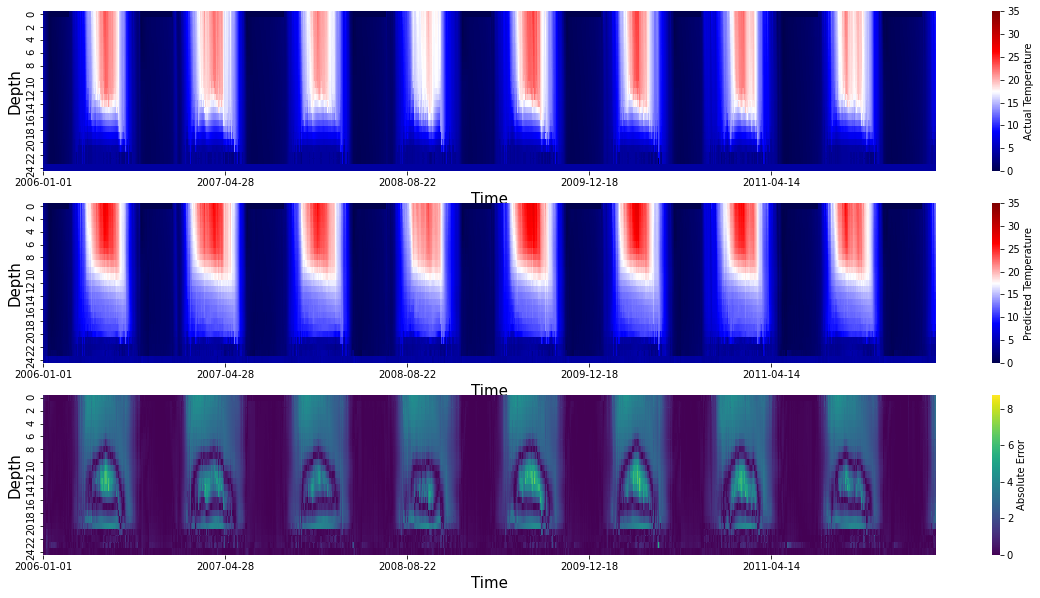

In [45]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

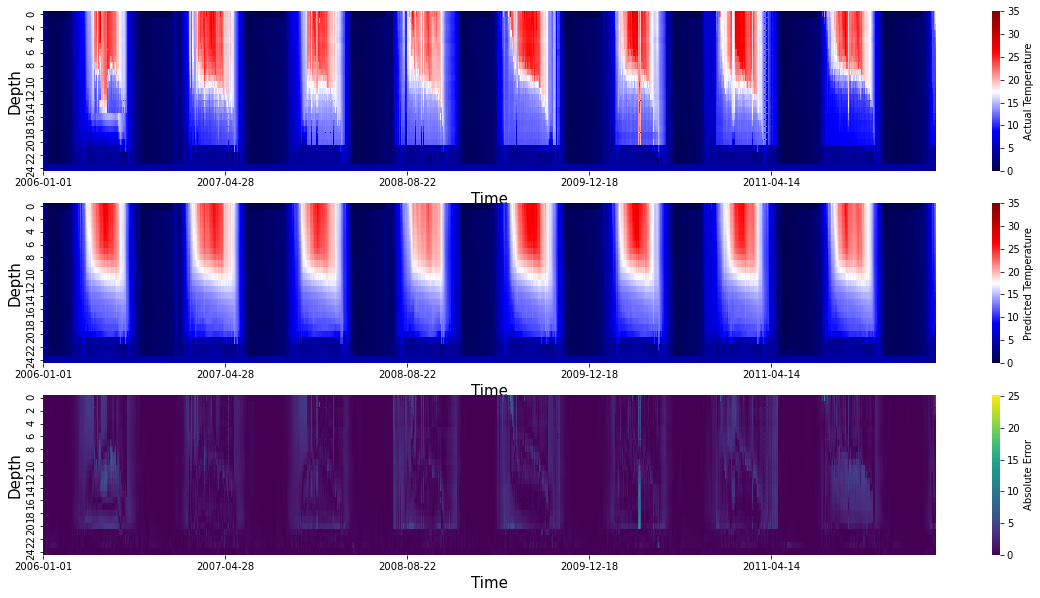

In [46]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [47]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.00040685644
RMSE of after m1 0.70851576
RMSE of after m2 2.4703825
RMSE of after m3 2.410914
RMSE of after m4 2.4112835
RMSE of after m0 0.00038437784
RMSE of after m1 0.6898497
RMSE of after m2 2.5687358
RMSE of after m3 2.5065577
RMSE of after m4 2.5069969
RMSE of after m0 0.0004228058
RMSE of after m1 0.67883325
RMSE of after m2 2.6209686
RMSE of after m3 2.5677288
RMSE of after m4 2.5682242
RMSE of after m0 0.00046273702
RMSE of after m1 0.68441147
RMSE of after m2 2.6378388
RMSE of after m3 2.5840905
RMSE of after m4 2.5846188
RMSE of after m0 0.00039467865
RMSE of after m1 0.6994464
RMSE of after m2 2.7017028
RMSE of after m3 2.652112
RMSE of after m4 2.652854
RMSE of after m0 0.00052658113
RMSE of after m1 0.6667265
RMSE of after m2 2.6136675
RMSE of after m3 2.5630238
RMSE of after m4 2.56402
RMSE of after m0 0.0005018738
RMSE of after m1 0.6667033
RMSE of after m2 2.4791393
RMSE of after m3 2.4166474
RMSE of after m4 2.4175415
RMSE of after m0 0.00052803336


RMSE of after m4 2.599651
RMSE of after m0 0.0012082981
RMSE of after m1 0.73672795
RMSE of after m2 2.5282035
RMSE of after m3 2.4706407
RMSE of after m4 2.4707422
RMSE of after m0 0.0013582847
RMSE of after m1 0.60484314
RMSE of after m2 2.6373699
RMSE of after m3 2.595791
RMSE of after m4 2.595874
RMSE of after m0 0.0012373602
RMSE of after m1 0.612518
RMSE of after m2 2.6329389
RMSE of after m3 2.591699
RMSE of after m4 2.591765
RMSE of after m0 0.0011532014
RMSE of after m1 0.63619417
RMSE of after m2 2.6247168
RMSE of after m3 2.5786765
RMSE of after m4 2.5787902
RMSE of after m0 0.0013080611
RMSE of after m1 0.64700353
RMSE of after m2 2.6140265
RMSE of after m3 2.5680428
RMSE of after m4 2.5682158
RMSE of after m0 0.0013135931
RMSE of after m1 0.6616044
RMSE of after m2 2.5446777
RMSE of after m3 2.4923468
RMSE of after m4 2.4925766
RMSE of after m0 0.0011701914
RMSE of after m1 0.65656495
RMSE of after m2 2.4094412
RMSE of after m3 2.3559914
RMSE of after m4 2.3563294
RMSE of 

RMSE of after m1 0.08967095
RMSE of after m2 0.26140717
RMSE of after m3 0.19735461
RMSE of after m4 0.19373286
RMSE of after m0 0.0004097349
RMSE of after m1 0.094859056
RMSE of after m2 0.2322497
RMSE of after m3 0.15552069
RMSE of after m4 0.15110998
RMSE of after m0 0.0003440113
RMSE of after m1 0.09595894
RMSE of after m2 0.26790988
RMSE of after m3 0.21420111
RMSE of after m4 0.21423185
RMSE of after m0 0.0002878693
RMSE of after m1 0.098249555
RMSE of after m2 0.22801031
RMSE of after m3 0.15423635
RMSE of after m4 0.14597675
RMSE of after m0 0.00029717395
RMSE of after m1 0.1006452
RMSE of after m2 0.23941684
RMSE of after m3 0.16828129
RMSE of after m4 0.15909104
RMSE of after m0 0.00034850588
RMSE of after m1 0.10033601
RMSE of after m2 0.23076339
RMSE of after m3 0.16130123
RMSE of after m4 0.15955475
RMSE of after m0 0.00039162496
RMSE of after m1 0.10306178
RMSE of after m2 0.22305724
RMSE of after m3 0.14941615
RMSE of after m4 0.1435474
RMSE of after m0 0.00035013154
RMS

RMSE of after m1 0.37626174
RMSE of after m2 0.26502904
RMSE of after m3 0.16805027
RMSE of after m4 0.16858071
RMSE of after m0 0.0002323085
RMSE of after m1 0.4058848
RMSE of after m2 0.27917364
RMSE of after m3 0.18311287
RMSE of after m4 0.1836321
RMSE of after m0 0.00027001742
RMSE of after m1 0.40407598
RMSE of after m2 0.38532808
RMSE of after m3 0.20716642
RMSE of after m4 0.20767602
RMSE of after m0 0.00026169073
RMSE of after m1 0.42485243
RMSE of after m2 0.2687624
RMSE of after m3 0.22177485
RMSE of after m4 0.22222365
RMSE of after m0 0.00026877175
RMSE of after m1 0.4459833
RMSE of after m2 0.3953052
RMSE of after m3 0.2195329
RMSE of after m4 0.21995
RMSE of after m0 0.0002687226
RMSE of after m1 0.47645605
RMSE of after m2 0.3458593
RMSE of after m3 0.25106603
RMSE of after m4 0.25133592
RMSE of after m0 0.0002905517
RMSE of after m1 0.5018131
RMSE of after m2 0.3213461
RMSE of after m3 0.26223087
RMSE of after m4 0.26242915
RMSE of after m0 0.00022457067
RMSE of after 

RMSE of after m4 2.5567195
RMSE of after m0 0.0010157909
RMSE of after m1 0.7074804
RMSE of after m2 2.6803756
RMSE of after m3 2.6306255
RMSE of after m4 2.6306534
RMSE of after m0 0.0009912002
RMSE of after m1 0.7098721
RMSE of after m2 2.7046876
RMSE of after m3 2.6550226
RMSE of after m4 2.6550825
RMSE of after m0 0.0009105121
RMSE of after m1 0.71782905
RMSE of after m2 2.696205
RMSE of after m3 2.6488461
RMSE of after m4 2.6488357
RMSE of after m0 0.0010811755
RMSE of after m1 0.7268438
RMSE of after m2 2.7716448
RMSE of after m3 2.7211485
RMSE of after m4 2.7210898
RMSE of after m0 0.0011181197
RMSE of after m1 0.737736
RMSE of after m2 2.875481
RMSE of after m3 2.8262122
RMSE of after m4 2.826184
RMSE of after m0 0.0010882803
RMSE of after m1 0.7459705
RMSE of after m2 2.7772272
RMSE of after m3 2.7269192
RMSE of after m4 2.7269237
RMSE of after m0 0.0010852212
RMSE of after m1 0.7571723
RMSE of after m2 2.8335826
RMSE of after m3 2.7797318
RMSE of after m4 2.7797327
RMSE of af

RMSE of after m0 0.00033148946
RMSE of after m1 0.61436754
RMSE of after m2 1.8673013
RMSE of after m3 1.7953522
RMSE of after m4 1.795569
RMSE of after m0 0.00031964268
RMSE of after m1 0.9293242
RMSE of after m2 1.8768882
RMSE of after m3 1.8078597
RMSE of after m4 1.8079784
RMSE of after m0 0.00050839555
RMSE of after m1 0.7516671
RMSE of after m2 1.8535466
RMSE of after m3 1.7548925
RMSE of after m4 1.7549853
RMSE of after m0 0.00047744467
RMSE of after m1 0.88778436
RMSE of after m2 1.8001889
RMSE of after m3 1.6627055
RMSE of after m4 1.662954
RMSE of after m0 0.00038081096
RMSE of after m1 0.6702264
RMSE of after m2 1.7755117
RMSE of after m3 1.6968559
RMSE of after m4 1.6972134
RMSE of after m0 0.0002975087
RMSE of after m1 1.1680342
RMSE of after m2 1.600308
RMSE of after m3 1.557346
RMSE of after m4 1.557823
RMSE of after m0 0.00048744958
RMSE of after m1 1.1870356
RMSE of after m2 1.5591419
RMSE of after m3 1.5068623
RMSE of after m4 1.5073425
RMSE of after m0 0.0002933542
R

RMSE of after m0 0.0003778885
RMSE of after m1 0.15247962
RMSE of after m2 0.1887681
RMSE of after m3 0.10138596
RMSE of after m4 0.097601056
RMSE of after m0 0.0002555054
RMSE of after m1 0.158156
RMSE of after m2 0.19624977
RMSE of after m3 0.08700145
RMSE of after m4 0.079784185
RMSE of after m0 0.00023661512
RMSE of after m1 0.1612463
RMSE of after m2 0.19742778
RMSE of after m3 0.08323687
RMSE of after m4 0.07271708
RMSE of after m0 0.00023254643
RMSE of after m1 0.16530949
RMSE of after m2 0.1931835
RMSE of after m3 0.08440968
RMSE of after m4 0.07728972
RMSE of after m0 0.00033540893
RMSE of after m1 0.1688676
RMSE of after m2 0.19662273
RMSE of after m3 0.102907635
RMSE of after m4 0.09971357
RMSE of after m0 0.00028553468
RMSE of after m1 0.17465355
RMSE of after m2 0.21085395
RMSE of after m3 0.06658117
RMSE of after m4 0.05269023
RMSE of after m0 0.00026307852
RMSE of after m1 0.18068834
RMSE of after m2 0.22051725
RMSE of after m3 0.07109676
RMSE of after m4 0.058105264
RMS

RMSE of after m0 0.0003687907
RMSE of after m1 0.71637946
RMSE of after m2 2.5002916
RMSE of after m3 2.4353628
RMSE of after m4 2.4357717
RMSE of after m0 0.0004129698
RMSE of after m1 0.7249356
RMSE of after m2 2.6599216
RMSE of after m3 2.598275
RMSE of after m4 2.5988705
RMSE of after m0 0.0004519933
RMSE of after m1 0.75164884
RMSE of after m2 2.5448084
RMSE of after m3 2.4786968
RMSE of after m4 2.4794478
RMSE of after m0 0.0004193826
RMSE of after m1 0.7298911
RMSE of after m2 2.5670445
RMSE of after m3 2.499928
RMSE of after m4 2.5007706
RMSE of after m0 0.00055873324
RMSE of after m1 0.6319365
RMSE of after m2 2.5703013
RMSE of after m3 2.5177908
RMSE of after m4 2.518779
RMSE of after m0 0.00051251764
RMSE of after m1 0.6454655
RMSE of after m2 2.5692492
RMSE of after m3 2.5148954
RMSE of after m4 2.5158353
RMSE of after m0 0.00053599675
RMSE of after m1 0.64723516
RMSE of after m2 2.5878022
RMSE of after m3 2.5357733
RMSE of after m4 2.536805
RMSE of after m0 0.00070356263
R

RMSE of after m3 2.516294
RMSE of after m4 2.5163555
RMSE of after m0 0.0009521364
RMSE of after m1 0.7660865
RMSE of after m2 2.7056632
RMSE of after m3 2.6476498
RMSE of after m4 2.6476722
RMSE of after m0 0.0011216482
RMSE of after m1 0.75018346
RMSE of after m2 2.65016
RMSE of after m3 2.5977247
RMSE of after m4 2.5977156
RMSE of after m0 0.0012326126
RMSE of after m1 0.7427693
RMSE of after m2 2.6059103
RMSE of after m3 2.5537543
RMSE of after m4 2.553789
RMSE of after m0 0.0013198389
RMSE of after m1 0.736833
RMSE of after m2 2.6830947
RMSE of after m3 2.6285303
RMSE of after m4 2.6286218
RMSE of after m0 0.0011238571
RMSE of after m1 0.7246804
RMSE of after m2 2.7225537
RMSE of after m3 2.6693785
RMSE of after m4 2.6695135
RMSE of after m0 0.00110753
RMSE of after m1 0.7251533
RMSE of after m2 2.6010637
RMSE of after m3 2.546393
RMSE of after m4 2.546575
RMSE of after m0 0.001050933
RMSE of after m1 0.705842
RMSE of after m2 2.5095725
RMSE of after m3 2.4556477
RMSE of after m4 

RMSE of after m2 0.3036069
RMSE of after m3 0.120224684
RMSE of after m4 0.11974347
RMSE of after m0 0.00032491784
RMSE of after m1 0.22874723
RMSE of after m2 0.318203
RMSE of after m3 0.16070628
RMSE of after m4 0.15812102
RMSE of after m0 0.00053031434
RMSE of after m1 0.21655376
RMSE of after m2 0.30306482
RMSE of after m3 0.15235595
RMSE of after m4 0.15005648
RMSE of after m0 0.00030361552
RMSE of after m1 0.20611031
RMSE of after m2 0.29879862
RMSE of after m3 0.16398294
RMSE of after m4 0.16382103
RMSE of after m0 0.00020848526
RMSE of after m1 0.19723184
RMSE of after m2 0.27472892
RMSE of after m3 0.13099538
RMSE of after m4 0.13143946
RMSE of after m0 0.00020427909
RMSE of after m1 0.18976136
RMSE of after m2 0.27681857
RMSE of after m3 0.1491116
RMSE of after m4 0.14946304
RMSE of after m0 0.00029357075
RMSE of after m1 0.18350415
RMSE of after m2 0.26483434
RMSE of after m3 0.15520479
RMSE of after m4 0.15406822
RMSE of after m0 0.00024621104
RMSE of after m1 0.17758526
RM

RMSE of after m0 0.00029712942
RMSE of after m1 0.39742777
RMSE of after m2 0.3239772
RMSE of after m3 0.19327739
RMSE of after m4 0.1937544
RMSE of after m0 0.00041988323
RMSE of after m1 0.46159542
RMSE of after m2 0.34956878
RMSE of after m3 0.22714166
RMSE of after m4 0.22746395
RMSE of after m0 0.00025050482
RMSE of after m1 0.5276685
RMSE of after m2 0.5000366
RMSE of after m3 0.308156
RMSE of after m4 0.3083348
RMSE of after m0 0.00023216866
RMSE of after m1 0.56969285
RMSE of after m2 0.5375007
RMSE of after m3 0.33479404
RMSE of after m4 0.33498627
RMSE of after m0 0.00049487775
RMSE of after m1 0.6107518
RMSE of after m2 0.4464988
RMSE of after m3 0.3682084
RMSE of after m4 0.3684516
RMSE of after m0 0.00030373453
RMSE of after m1 0.67077863
RMSE of after m2 0.6667833
RMSE of after m3 0.51100737
RMSE of after m4 0.5113175
RMSE of after m0 0.00021293068
RMSE of after m1 0.71440655
RMSE of after m2 0.76413256
RMSE of after m3 0.6191626
RMSE of after m4 0.61947083
RMSE of after 

RMSE of after m2 2.813083
RMSE of after m3 2.7518818
RMSE of after m4 2.7515013
RMSE of after m0 0.001022324
RMSE of after m1 0.7725636
RMSE of after m2 2.911381
RMSE of after m3 2.8553684
RMSE of after m4 2.8550382
RMSE of after m0 0.0011810607
RMSE of after m1 0.7714011
RMSE of after m2 2.8919308
RMSE of after m3 2.837944
RMSE of after m4 2.8377001
RMSE of after m0 0.0010996646
RMSE of after m1 0.77395093
RMSE of after m2 2.802745
RMSE of after m3 2.751767
RMSE of after m4 2.751573
RMSE of after m0 0.0010644913
RMSE of after m1 0.7784285
RMSE of after m2 2.709345
RMSE of after m3 2.654929
RMSE of after m4 2.654687
RMSE of after m0 0.0010478648
RMSE of after m1 0.7824664
RMSE of after m2 2.6470604
RMSE of after m3 2.5887067
RMSE of after m4 2.58847
RMSE of after m0 0.0013391945
RMSE of after m1 0.78548914
RMSE of after m2 2.8827646
RMSE of after m3 2.8264892
RMSE of after m4 2.8264842
RMSE of after m0 0.0010942591
RMSE of after m1 0.79152656
RMSE of after m2 3.017839
RMSE of after m3 

RMSE of after m0 0.0001623464
RMSE of after m1 0.7361459
RMSE of after m2 1.0201707
RMSE of after m3 0.95619446
RMSE of after m4 0.9566344
RMSE of after m0 0.00017618957
RMSE of after m1 0.69592816
RMSE of after m2 0.75018823
RMSE of after m3 0.7299944
RMSE of after m4 0.73028445
RMSE of after m0 0.00018171579
RMSE of after m1 0.63540715
RMSE of after m2 0.65324295
RMSE of after m3 0.6565148
RMSE of after m4 0.65666264
RMSE of after m0 0.00022670113
RMSE of after m1 0.5681022
RMSE of after m2 0.7220499
RMSE of after m3 0.5979987
RMSE of after m4 0.5981061
RMSE of after m0 0.00021758495
RMSE of after m1 0.48840395
RMSE of after m2 0.60312635
RMSE of after m3 0.49594355
RMSE of after m4 0.49604926
RMSE of after m0 0.00023871832
RMSE of after m1 0.43197733
RMSE of after m2 0.4996599
RMSE of after m3 0.4159443
RMSE of after m4 0.41610336
RMSE of after m0 0.00024067899
RMSE of after m1 0.39770803
RMSE of after m2 0.508792
RMSE of after m3 0.4265759
RMSE of after m4 0.4267573
RMSE of after m

RMSE of after m0 0.00029518802
RMSE of after m1 0.2159183
RMSE of after m2 0.25669047
RMSE of after m3 0.091084816
RMSE of after m4 0.081552066
RMSE of after m0 0.00033232462
RMSE of after m1 0.21686387
RMSE of after m2 0.2625045
RMSE of after m3 0.093591906
RMSE of after m4 0.08174211
RMSE of after m0 0.0003622582
RMSE of after m1 0.21957424
RMSE of after m2 0.26323617
RMSE of after m3 0.11157657
RMSE of after m4 0.10890394
RMSE of after m0 0.000320766
RMSE of after m1 0.22430101
RMSE of after m2 0.26263624
RMSE of after m3 0.08492243
RMSE of after m4 0.074676804
RMSE of after m0 0.0002923182
RMSE of after m1 0.2294663
RMSE of after m2 0.2608321
RMSE of after m3 0.067537665
RMSE of after m4 0.056323778
RMSE of after m0 0.00025542133
RMSE of after m1 0.23480956
RMSE of after m2 0.26745945
RMSE of after m3 0.070565835
RMSE of after m4 0.059078436
RMSE of after m0 0.00023886567
RMSE of after m1 0.24341099
RMSE of after m2 0.26419464
RMSE of after m3 0.049285393
RMSE of after m4 0.0403268

RMSE of after m3 2.692465
RMSE of after m4 2.693872
RMSE of after m0 0.0004650698
RMSE of after m1 0.6866752
RMSE of after m2 2.7380044
RMSE of after m3 2.685264
RMSE of after m4 2.6869254
RMSE of after m0 0.0005427833
RMSE of after m1 0.69770485
RMSE of after m2 2.7477734
RMSE of after m3 2.6964219
RMSE of after m4 2.6983066
RMSE of after m0 0.00064476614
RMSE of after m1 0.70823026
RMSE of after m2 2.6383662
RMSE of after m3 2.581675
RMSE of after m4 2.5833447
RMSE of after m0 0.0005919998
RMSE of after m1 0.71412265
RMSE of after m2 2.5333364
RMSE of after m3 2.4706624
RMSE of after m4 2.4723146
RMSE of after m0 0.0006205558
RMSE of after m1 0.66855574
RMSE of after m2 2.5408597
RMSE of after m3 2.4818363
RMSE of after m4 2.483459
RMSE of after m0 0.00059529464
RMSE of after m1 0.63775045
RMSE of after m2 2.5507014
RMSE of after m3 2.497477
RMSE of after m4 2.4991262
RMSE of after m0 0.0005809629
RMSE of after m1 0.62104785
RMSE of after m2 2.586639
RMSE of after m3 2.5325937
RMSE o

RMSE of after m0 0.0009913582
RMSE of after m1 0.72285956
RMSE of after m2 2.295173
RMSE of after m3 2.2374914
RMSE of after m4 2.2377002
RMSE of after m0 0.000974055
RMSE of after m1 0.7201108
RMSE of after m2 2.2210119
RMSE of after m3 2.1613097
RMSE of after m4 2.1615663
RMSE of after m0 0.0009749311
RMSE of after m1 0.7299674
RMSE of after m2 2.163815
RMSE of after m3 2.097684
RMSE of after m4 2.0980446
RMSE of after m0 0.0013351442
RMSE of after m1 0.7090034
RMSE of after m2 2.2832146
RMSE of after m3 2.227302
RMSE of after m4 2.227668
RMSE of after m0 0.0011693797
RMSE of after m1 0.6307402
RMSE of after m2 2.3407633
RMSE of after m3 2.2882953
RMSE of after m4 2.288757
RMSE of after m0 0.0010221215
RMSE of after m1 0.608332
RMSE of after m2 2.2610047
RMSE of after m3 2.2083883
RMSE of after m4 2.2089298
RMSE of after m0 0.0012721404
RMSE of after m1 0.63031316
RMSE of after m2 2.2644672
RMSE of after m3 2.2106538
RMSE of after m4 2.2112563
RMSE of after m0 0.001215277
RMSE of aft

RMSE of after m0 0.0001804749
RMSE of after m1 0.14061789
RMSE of after m2 0.24552274
RMSE of after m3 0.16559242
RMSE of after m4 0.15739936
RMSE of after m0 0.00021037016
RMSE of after m1 0.1435199
RMSE of after m2 0.25770882
RMSE of after m3 0.17346242
RMSE of after m4 0.16765508
RMSE of after m0 0.00021363792
RMSE of after m1 0.14766087
RMSE of after m2 0.24928685
RMSE of after m3 0.15714157
RMSE of after m4 0.1507018
RMSE of after m0 0.00022432972
RMSE of after m1 0.15060665
RMSE of after m2 0.25660115
RMSE of after m3 0.16232151
RMSE of after m4 0.15606159
RMSE of after m0 0.00026916357
RMSE of after m1 0.15230773
RMSE of after m2 0.25770253
RMSE of after m3 0.16312097
RMSE of after m4 0.1531958
RMSE of after m0 0.00020934873
RMSE of after m1 0.15595064
RMSE of after m2 0.29381514
RMSE of after m3 0.20265026
RMSE of after m4 0.19771454
RMSE of after m0 0.00018265747
RMSE of after m1 0.15927604
RMSE of after m2 0.281179
RMSE of after m3 0.18128821
RMSE of after m4 0.17515476
RMSE 

RMSE of after m0 0.00017590098
RMSE of after m1 0.7218593
RMSE of after m2 1.032746
RMSE of after m3 0.91693485
RMSE of after m4 0.91724086
RMSE of after m0 0.00018839168
RMSE of after m1 0.7327313
RMSE of after m2 1.1055133
RMSE of after m3 0.97294825
RMSE of after m4 0.9732462
RMSE of after m0 0.00018681599
RMSE of after m1 0.6815413
RMSE of after m2 1.2282813
RMSE of after m3 1.0798565
RMSE of after m4 1.0801302
RMSE of after m0 0.00020857633
RMSE of after m1 0.700381
RMSE of after m2 1.2684005
RMSE of after m3 1.131763
RMSE of after m4 1.132047
RMSE of after m0 0.00020554406
RMSE of after m1 0.72760075
RMSE of after m2 1.3410894
RMSE of after m3 1.2266554
RMSE of after m4 1.2269174
RMSE of after m0 0.00018313587
RMSE of after m1 0.80448014
RMSE of after m2 1.2402967
RMSE of after m3 1.2196498
RMSE of after m4 1.219911
RMSE of after m0 0.00020211742
RMSE of after m1 0.78710234
RMSE of after m2 1.4485769
RMSE of after m3 1.3783928
RMSE of after m4 1.3786428
RMSE of after m0 0.0001848

RMSE of after m0 0.0013190351
RMSE of after m1 0.76684445
RMSE of after m2 2.8391352
RMSE of after m3 2.7865558
RMSE of after m4 2.786438
RMSE of after m0 0.0010830801
RMSE of after m1 0.7697746
RMSE of after m2 2.791108
RMSE of after m3 2.7401934
RMSE of after m4 2.7401793
RMSE of after m0 0.0009748772
RMSE of after m1 0.77035314
RMSE of after m2 2.709086
RMSE of after m3 2.6589286
RMSE of after m4 2.6588402
RMSE of after m0 0.0011371538
RMSE of after m1 0.7701864
RMSE of after m2 2.6657207
RMSE of after m3 2.6109033
RMSE of after m4 2.6108603
RMSE of after m0 0.0011432061
RMSE of after m1 0.77374506
RMSE of after m2 2.6644492
RMSE of after m3 2.6083179
RMSE of after m4 2.6083586
RMSE of after m0 0.0010585308
RMSE of after m1 0.7766846
RMSE of after m2 2.7244916
RMSE of after m3 2.6683993
RMSE of after m4 2.6684525
RMSE of after m0 0.0010639125
RMSE of after m1 0.7735268
RMSE of after m2 2.7404056
RMSE of after m3 2.6885114
RMSE of after m4 2.6885514
RMSE of after m0 0.001110199
RMSE 

RMSE of after m3 0.4423078
RMSE of after m4 0.4424381
RMSE of after m0 0.00033881795
RMSE of after m1 0.17491144
RMSE of after m2 0.3860747
RMSE of after m3 0.43810076
RMSE of after m4 0.43820032
RMSE of after m0 0.00034412605
RMSE of after m1 0.15426096
RMSE of after m2 0.8456726
RMSE of after m3 0.8653637
RMSE of after m4 0.86550444
RMSE of after m0 0.00031410626
RMSE of after m1 0.1408764
RMSE of after m2 0.32318205
RMSE of after m3 0.36002925
RMSE of after m4 0.3600726
RMSE of after m0 0.00035758264
RMSE of after m1 0.12357992
RMSE of after m2 0.6713469
RMSE of after m3 0.68802464
RMSE of after m4 0.68808067
RMSE of after m0 0.00034692432
RMSE of after m1 0.10605619
RMSE of after m2 0.5048837
RMSE of after m3 0.54315484
RMSE of after m4 0.54326046
RMSE of after m0 0.00037369842
RMSE of after m1 0.078657895
RMSE of after m2 0.5160849
RMSE of after m3 0.53993964
RMSE of after m4 0.53985995
RMSE of after m0 0.0004671795
RMSE of after m1 0.0673249
RMSE of after m2 0.18857716
RMSE of af

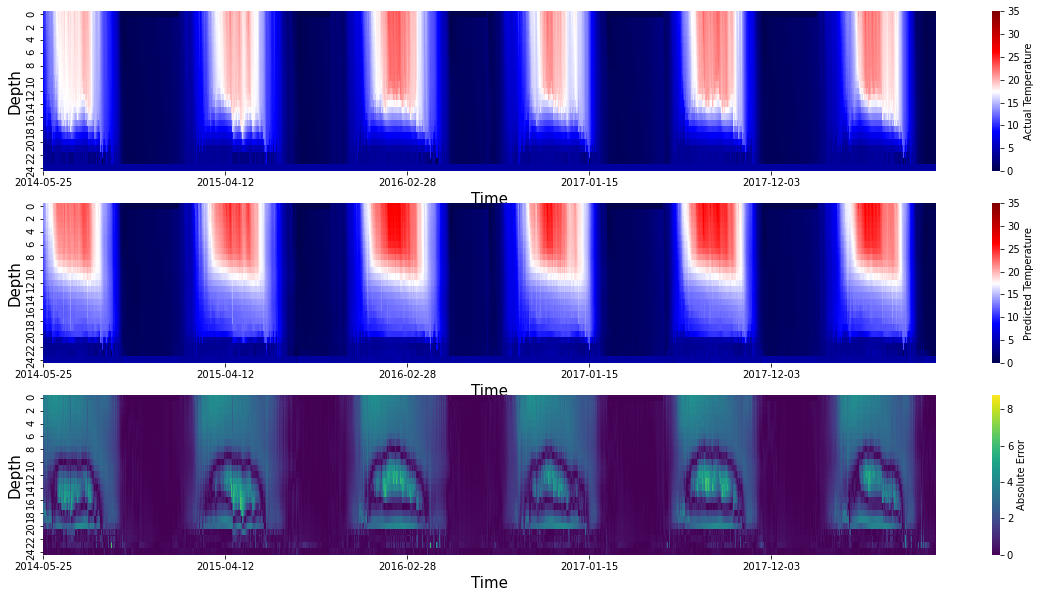

In [48]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

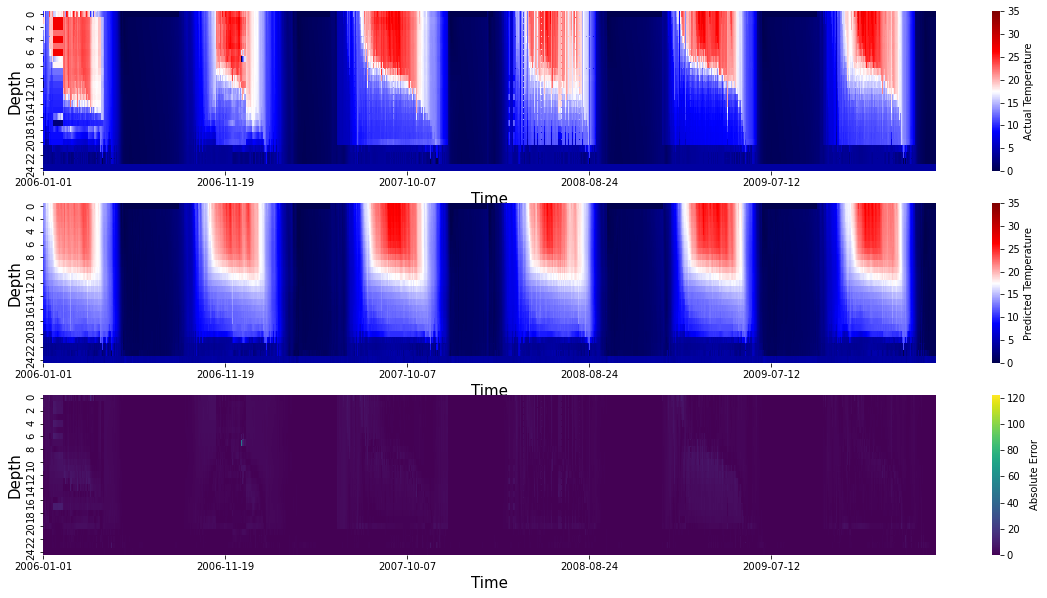

In [49]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [50]:
train_rmse, train_l2_err = compute_metrics(heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 11.395342155022304, Train L2 Error: 1.1868947968576393
Test RMSE: 12.028427025260507, Train L2 Error: 1.1740138800862012


## Mixing Model

In [51]:
train_rmse, train_l2_err = compute_metrics(mixing_model, train_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(mixing_model, test_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 1.771638465792629, Train L2 Error: 0.18442277855121747
Test RMSE: 1.836193539288039, Train L2 Error: 0.17914328539732838


## Convection Model

In [52]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.10238946186873105, Train L2 Error: 0.010641804283639112
Test RMSE: 0.11916663876987295, Train L2 Error: 0.011609599613482435


## Ice Model

In [53]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.0011646093493033137, Train L2 Error: 0.00012104342580499258
Test RMSE: 0.0022081818962783406, Train L2 Error: 0.00021512855883762218


# Compute Model Similarity after Finetuning

In [54]:
def compute_model_similarity(model1, model2):
    weight1 = []
    weight2 = []
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        weight1.append(param1.detach().clone().flatten())
        weight2.append(param2.detach().clone().flatten())
    weight1 = torch.cat(weight1, dim=0)
    weight2 = torch.cat(weight2, dim=0)
    
    #Cosine Similarity
    cos = nn.CosineSimilarity(dim=0, eps=1e-8)
    cos_sim = cos(weight1, weight2)
    
    #L2 norm
    l2 = torch.norm((weight1-weight2), p='fro', dim=0)
    
    return cos_sim, l2

In [55]:
heating_model_init = MLP(m0_layers, activation="gelu")
heating_model_init.load_state_dict(m0_checkpoint)
heating_model_init = heating_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heating_model_init, heating_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [56]:
heat_diff_model_init = MLP(m1_layers, activation="gelu")
heat_diff_model_init.load_state_dict(m1_checkpoint)
heat_diff_model_init = heat_diff_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heat_diff_model_init, heat_diff_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [57]:
mixing_model_init = MLP(m2_layers, activation="gelu")
mixing_model_init.load_state_dict(m2_checkpoint)
mixing_model_init = mixing_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(mixing_model_init, mixing_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 0.9941015243530273
L2 Norm: 4.932139873504639


In [58]:
convection_model_init = MLP(m3_layers, activation="gelu")
convection_model_init.load_state_dict(m3_checkpoint)
convection_model_init = convection_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(convection_model_init, convection_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [59]:
ice_model_init = MLP(m4_layers, activation="gelu")
ice_model_init.load_state_dict(m4_checkpoint)
ice_model_init = ice_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(ice_model_init, ice_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [60]:
# Freeze all models again and compute finetuned diffusivity values

In [61]:
# Unfreeze diffusion model and finetune it on projected diffusivities